In [3]:
import os
import pandas as pd
import re
from tqdm import tqdm

basic_info_df = pd.read_csv('generated/data/parkings_info.csv')
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))

In [5]:
from IPython.display import Image, display
from datetime import date, timedelta
import pandas as pd
import numpy as np

def build_area_seqs(target_area, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'generated/data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df)>0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')

In [6]:
from graph_utils import build_graph

target_park = '电影大厦'
target_area, adj, target_map, nks, kns = build_graph(basic_info_df, target_park)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]

seqs_raw = build_area_seqs(target_area, start='2016-10-01', end='2016-11-01')
# normalization
seqs_normal = seqs_raw/seqs_raw.max()

In [7]:
def get_nodes_features(area_df):
    node_f = area_df[['total_space','monthly_fee','building_type']]
    node_f['total_space'] = node_f.total_space/node_f.total_space.max()
    node_f['monthly_fee'] = node_f.monthly_fee/node_f.monthly_fee.max()
    building_type_oneHot = pd.get_dummies(node_f['building_type'])
    node_f = node_f.drop('building_type',axis = 1)
    node_f = node_f.join(building_type_oneHot)
    return node_f

In [8]:
node_f = get_nodes_features(target_area)

<ipython-input-7-6246592cf25e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_f['total_space'] = node_f.total_space/node_f.total_space.max()
<ipython-input-7-6246592cf25e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_f['monthly_fee'] = node_f.monthly_fee/node_f.monthly_fee.max()


In [79]:
import tensorflow as tf
from abc import ABC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GRU, Flatten, Dense, LeakyReLU
from spektral.layers import GraphConv

l2_reg = 5e-4 / 2  # L2 regularization rate


class Generator(Model, ABC):

    def __init__(self, adj, nodes_features):
        super(Generator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(32,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(16,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(32, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # 11*F
        g = tf.convert_to_tensor(self.adj)  # 11*11
        s = tf.convert_to_tensor(seq)  # 96*11

        c = self.graph_conv_1([f, g])  # 11*11
        c = self.graph_conv_2([c, g])  # 11*11
        s = tf.matmul(s, c)  # 96*11

        fc = self.dense_1(s)  # 96*32
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*32
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)  # 1*96*32
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*32
        return self.final_dense(ro)  # 96*1


class Discriminator(Model, ABC):

    def __init__(self, adj, nodes_features):
        super(Discriminator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.leaky_relu = LeakyReLU(alpha=0.2)
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(32,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(16,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(32)
        self.dense_2 = Dense(64)
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='sigmoid')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # 11*F
        g = tf.convert_to_tensor(self.adj)  # 11*11
        s = tf.convert_to_tensor(seq)  # 96*11

        c = self.graph_conv_1([f, g])  # 11*11
        c = self.graph_conv_2([c, g])  # 11*11
        s = tf.matmul(s, c)  # 96*11

        fc = self.dense_1(s)  # 96*32
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*64
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*64
        return self.final_dense(ro)  # 96*1


In [80]:
import os
from tensorflow.keras.optimizers import Adam
from spektral.utils import normalized_laplacian
# from model import Generator, Discriminator
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 96
save_interval = 5
learning_rate = 1e-3
adam_beta_1 = 0.5


class Train:
    def __init__(self, seqs, adj, nodes_features, epochs=1000, key=9):
        self.epochs = epochs
        self.seqs = seqs.astype('float32')

        self.gen_optimizer = Adam(learning_rate, adam_beta_1)
        self.desc_optimizer = Adam(learning_rate, adam_beta_1)

        self.adj = normalized_laplacian(adj.astype('float32'))
        self.nodes_features = nodes_features.astype('float32')
        self.generator = Generator(self.adj, self.nodes_features)
        self.discriminator = Discriminator(self.adj, self.nodes_features)

        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.key = key

    def __call__(self, save_path='generated/saved'):
        save_path += str(time.time())
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        time_len = self.seqs.shape[0]
        num_nodes = self.seqs.shape[1]
        total_batch = int(time_len / batch_size)  # 2976/96=31

        time_consumed_total = 0.
        for epoch in range(1, self.epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0

            for week in range(0, total_batch):
                current_seqs = self.seqs[week:week + batch_size]
                seqs_noised = current_seqs.copy()
                max_s = current_seqs[self.key].max()
                seqs_noised[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0,
                                                         size=(current_seqs.shape[0])).astype('float32')
                gen_loss, disc_loss = self.train_step(current_seqs, seqs_noised)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            self.epochs_last = self.epochs - epoch
            estimate_time_last = self.epochs_last * time_consumed_agv
            print('epoch {}({})/{}({}) - gen_loss = {}, disc_loss = {}, estimated to finish: {}'
                  .format(epoch, round(time.time() - start, 2),
                          self.epochs, round(time_consumed_total, 2),
                          round(float(total_gen_loss / total_batch), 5),
                          round(float(total_disc_loss / total_batch), 5),
                          round(estimate_time_last, 2)))

            if epoch % save_interval == 0:
                plot = self.generate()
                fig = plot.get_figure()
                fig.savefig(save_path + "/gen_" + str(epoch) + ".png")
                plt.clf()

    @tf.function
    def train_step(self, seqs, seqs_noised):
        with tf.GradientTape(persistent=True) as tape:
            real_output = self.discriminator(seqs)  # 评价高
            generated = self.generator(seqs_noised)
            left = tf.slice(seqs, [0, 0], [batch_size, self.key])
            right = tf.slice(seqs, [0, self.key + 1], [batch_size, -1])
            combined = tf.concat([left, generated, right], 1)
            generated_output = self.discriminator(combined)  # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d

    def generate(self):
        import random as random
        week = 1 # random.randint(0,31)
        seqs_replace = self.seqs[week:week + batch_size].copy()
        max_s = seqs_replace[self.key].max()
        seqs_replace[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0, size=(seqs_replace.shape[0])).astype(
            'float32')
        gen_data = self.generator(seqs_replace, training=False)

        from sklearn import preprocessing
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(gen_data.numpy())
        return pd.DataFrame(x_scaled).plot()  # [self.key]

    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        """
        ...
        """
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        """
        ...
        """
        return loss_object(tf.ones_like(fake_output), fake_output)

In [ ]:
train = Train(seqs_normal, adj, node_f, 2000)
train()

epoch 1(4.18)/2000(4.18) - gen_loss = 0.73041, disc_loss = 1.38358, estimated to finish: 8351.82
epoch 2(0.89)/2000(5.06) - gen_loss = 0.68544, disc_loss = 1.39073, estimated to finish: 5059.93
epoch 3(0.88)/2000(5.95) - gen_loss = 0.70753, disc_loss = 1.36798, estimated to finish: 3958.72
epoch 4(0.87)/2000(6.82) - gen_loss = 0.71821, disc_loss = 1.40561, estimated to finish: 3403.68
epoch 5(0.89)/2000(7.71) - gen_loss = 0.56756, disc_loss = 1.41268, estimated to finish: 3076.69
epoch 6(0.87)/2000(8.58) - gen_loss = 0.70204, disc_loss = 1.348, estimated to finish: 2852.08
epoch 7(0.88)/2000(9.46) - gen_loss = 0.67835, disc_loss = 1.36666, estimated to finish: 2692.54
epoch 8(0.9)/2000(10.35) - gen_loss = 0.70288, disc_loss = 1.37416, estimated to finish: 2577.89
epoch 9(0.89)/2000(11.24) - gen_loss = 0.6999, disc_loss = 1.38072, estimated to finish: 2486.31
epoch 10(0.98)/2000(12.21) - gen_loss = 0.70235, disc_loss = 1.37963, estimated to finish: 2430.78
epoch 11(0.9)/2000(13.12) - ge

epoch 85(0.92)/2000(81.95) - gen_loss = 0.69601, disc_loss = 1.38213, estimated to finish: 1846.28
epoch 86(0.91)/2000(82.86) - gen_loss = 0.69298, disc_loss = 1.38707, estimated to finish: 1844.1
epoch 87(0.92)/2000(83.78) - gen_loss = 0.69696, disc_loss = 1.38543, estimated to finish: 1842.25
epoch 88(0.94)/2000(84.72) - gen_loss = 0.69293, disc_loss = 1.38697, estimated to finish: 1840.76
epoch 89(0.9)/2000(85.62) - gen_loss = 0.69775, disc_loss = 1.38536, estimated to finish: 1838.37
epoch 90(0.9)/2000(86.52) - gen_loss = 0.6913, disc_loss = 1.38671, estimated to finish: 1836.06
epoch 91(0.91)/2000(87.43) - gen_loss = 0.7005, disc_loss = 1.38183, estimated to finish: 1834.04
epoch 92(0.93)/2000(88.35) - gen_loss = 0.69886, disc_loss = 1.38174, estimated to finish: 1832.34
epoch 93(0.91)/2000(89.26) - gen_loss = 0.69702, disc_loss = 1.38279, estimated to finish: 1830.31
epoch 94(0.89)/2000(90.15) - gen_loss = 0.69156, disc_loss = 1.38708, estimated to finish: 1827.91
epoch 95(0.88)/

C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 106(0.94)/2000(101.17) - gen_loss = 0.69718, disc_loss = 1.38387, estimated to finish: 1807.73
epoch 107(0.9)/2000(102.07) - gen_loss = 0.69256, disc_loss = 1.38604, estimated to finish: 1805.79
epoch 108(0.91)/2000(102.98) - gen_loss = 0.69527, disc_loss = 1.3902, estimated to finish: 1804.01
epoch 109(0.96)/2000(103.94) - gen_loss = 0.69356, disc_loss = 1.38724, estimated to finish: 1803.17
epoch 110(0.97)/2000(104.9) - gen_loss = 0.68841, disc_loss = 1.39095, estimated to finish: 1802.44


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 111(0.92)/2000(105.82) - gen_loss = 0.6942, disc_loss = 1.38847, estimated to finish: 1800.9
epoch 112(0.95)/2000(106.77) - gen_loss = 0.69312, disc_loss = 1.38741, estimated to finish: 1799.84
epoch 113(0.96)/2000(107.73) - gen_loss = 0.69664, disc_loss = 1.38239, estimated to finish: 1798.94
epoch 114(1.03)/2000(108.76) - gen_loss = 0.69451, disc_loss = 1.38545, estimated to finish: 1799.3
epoch 115(1.0)/2000(109.76) - gen_loss = 0.69623, disc_loss = 1.38543, estimated to finish: 1799.16


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 116(0.93)/2000(110.69) - gen_loss = 0.69286, disc_loss = 1.38561, estimated to finish: 1797.82
epoch 117(0.93)/2000(111.62) - gen_loss = 0.69474, disc_loss = 1.38681, estimated to finish: 1796.41
epoch 118(0.98)/2000(112.6) - gen_loss = 0.69209, disc_loss = 1.38631, estimated to finish: 1795.8
epoch 119(1.11)/2000(113.71) - gen_loss = 0.7026, disc_loss = 1.38075, estimated to finish: 1797.3
epoch 120(1.14)/2000(114.85) - gen_loss = 0.69605, disc_loss = 1.38344, estimated to finish: 1799.24


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 121(0.99)/2000(115.84) - gen_loss = 0.69277, disc_loss = 1.39064, estimated to finish: 1798.81
epoch 122(0.94)/2000(116.78) - gen_loss = 0.69533, disc_loss = 1.38689, estimated to finish: 1797.64
epoch 123(0.95)/2000(117.73) - gen_loss = 0.69791, disc_loss = 1.38228, estimated to finish: 1796.52
epoch 124(0.94)/2000(118.67) - gen_loss = 0.69283, disc_loss = 1.38863, estimated to finish: 1795.36
epoch 125(1.05)/2000(119.72) - gen_loss = 0.68788, disc_loss = 1.39168, estimated to finish: 1795.74


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 126(1.08)/2000(120.79) - gen_loss = 0.68794, disc_loss = 1.3895, estimated to finish: 1796.56
epoch 127(1.1)/2000(121.9) - gen_loss = 0.69932, disc_loss = 1.38297, estimated to finish: 1797.75
epoch 128(1.1)/2000(123.0) - gen_loss = 0.69464, disc_loss = 1.38553, estimated to finish: 1798.91
epoch 129(1.01)/2000(124.02) - gen_loss = 0.69201, disc_loss = 1.38819, estimated to finish: 1798.73
epoch 130(1.0)/2000(125.02) - gen_loss = 0.68741, disc_loss = 1.39433, estimated to finish: 1798.33


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 131(1.04)/2000(126.06) - gen_loss = 0.69132, disc_loss = 1.39294, estimated to finish: 1798.51
epoch 132(1.06)/2000(127.12) - gen_loss = 0.69113, disc_loss = 1.38781, estimated to finish: 1798.9
epoch 133(0.95)/2000(128.07) - gen_loss = 0.70129, disc_loss = 1.38535, estimated to finish: 1797.74
epoch 134(0.96)/2000(129.02) - gen_loss = 0.69125, disc_loss = 1.38774, estimated to finish: 1796.72
epoch 135(0.96)/2000(129.99) - gen_loss = 0.69498, disc_loss = 1.38625, estimated to finish: 1795.73


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 136(0.94)/2000(130.93) - gen_loss = 0.6905, disc_loss = 1.38822, estimated to finish: 1794.48
epoch 137(0.92)/2000(131.85) - gen_loss = 0.69414, disc_loss = 1.38765, estimated to finish: 1793.0
epoch 138(0.92)/2000(132.77) - gen_loss = 0.691, disc_loss = 1.38833, estimated to finish: 1791.45
epoch 139(0.92)/2000(133.69) - gen_loss = 0.69266, disc_loss = 1.38684, estimated to finish: 1789.96
epoch 140(0.96)/2000(134.65) - gen_loss = 0.69158, disc_loss = 1.38786, estimated to finish: 1788.96


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 141(0.93)/2000(135.58) - gen_loss = 0.6932, disc_loss = 1.38797, estimated to finish: 1787.53
epoch 142(0.99)/2000(136.56) - gen_loss = 0.69698, disc_loss = 1.38595, estimated to finish: 1786.88
epoch 143(0.91)/2000(137.47) - gen_loss = 0.69455, disc_loss = 1.38569, estimated to finish: 1785.21
epoch 144(0.91)/2000(138.38) - gen_loss = 0.69183, disc_loss = 1.38855, estimated to finish: 1783.55
epoch 145(0.92)/2000(139.29) - gen_loss = 0.68755, disc_loss = 1.38759, estimated to finish: 1782.0


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 146(0.96)/2000(140.26) - gen_loss = 0.69869, disc_loss = 1.38379, estimated to finish: 1781.09
epoch 147(1.01)/2000(141.27) - gen_loss = 0.69629, disc_loss = 1.3864, estimated to finish: 1780.8
epoch 148(1.07)/2000(142.34) - gen_loss = 0.69359, disc_loss = 1.38575, estimated to finish: 1781.2
epoch 149(0.9)/2000(143.25) - gen_loss = 0.69132, disc_loss = 1.38843, estimated to finish: 1779.52
epoch 150(0.91)/2000(144.16) - gen_loss = 0.68949, disc_loss = 1.38929, estimated to finish: 1777.92


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 151(0.9)/2000(145.06) - gen_loss = 0.69242, disc_loss = 1.38609, estimated to finish: 1776.24
epoch 152(0.92)/2000(145.98) - gen_loss = 0.69846, disc_loss = 1.38471, estimated to finish: 1774.79
epoch 153(0.89)/2000(146.87) - gen_loss = 0.69673, disc_loss = 1.38683, estimated to finish: 1772.98
epoch 154(0.91)/2000(147.78) - gen_loss = 0.68715, disc_loss = 1.38913, estimated to finish: 1771.46
epoch 155(0.89)/2000(148.67) - gen_loss = 0.68995, disc_loss = 1.38831, estimated to finish: 1769.61


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 156(0.91)/2000(149.57) - gen_loss = 0.68387, disc_loss = 1.388, estimated to finish: 1768.03
epoch 157(0.91)/2000(150.48) - gen_loss = 0.69697, disc_loss = 1.38661, estimated to finish: 1766.44
epoch 158(0.93)/2000(151.41) - gen_loss = 0.69799, disc_loss = 1.38459, estimated to finish: 1765.15
epoch 159(0.91)/2000(152.32) - gen_loss = 0.69257, disc_loss = 1.38798, estimated to finish: 1763.61
epoch 160(0.89)/2000(153.2) - gen_loss = 0.69364, disc_loss = 1.3871, estimated to finish: 1761.82


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 161(0.89)/2000(154.09) - gen_loss = 0.68785, disc_loss = 1.38826, estimated to finish: 1760.05
epoch 162(0.9)/2000(154.99) - gen_loss = 0.69255, disc_loss = 1.3876, estimated to finish: 1758.43
epoch 163(0.9)/2000(155.89) - gen_loss = 0.69701, disc_loss = 1.38599, estimated to finish: 1756.83
epoch 164(1.01)/2000(156.89) - gen_loss = 0.69182, disc_loss = 1.38667, estimated to finish: 1756.43
epoch 165(1.0)/2000(157.89) - gen_loss = 0.69256, disc_loss = 1.38655, estimated to finish: 1755.91


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 166(0.94)/2000(158.82) - gen_loss = 0.69108, disc_loss = 1.38631, estimated to finish: 1754.72
epoch 167(1.02)/2000(159.84) - gen_loss = 0.69111, disc_loss = 1.38682, estimated to finish: 1754.41
epoch 168(0.95)/2000(160.79) - gen_loss = 0.69302, disc_loss = 1.3874, estimated to finish: 1753.4
epoch 169(0.96)/2000(161.75) - gen_loss = 0.6927, disc_loss = 1.38691, estimated to finish: 1752.49
epoch 170(0.93)/2000(162.68) - gen_loss = 0.69447, disc_loss = 1.38628, estimated to finish: 1751.22


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 171(0.93)/2000(163.62) - gen_loss = 0.69358, disc_loss = 1.38507, estimated to finish: 1750.02
epoch 172(0.94)/2000(164.55) - gen_loss = 0.6948, disc_loss = 1.38639, estimated to finish: 1748.84
epoch 173(0.93)/2000(165.48) - gen_loss = 0.69221, disc_loss = 1.38681, estimated to finish: 1747.63
epoch 174(0.94)/2000(166.43) - gen_loss = 0.69593, disc_loss = 1.38458, estimated to finish: 1746.52
epoch 175(0.91)/2000(167.33) - gen_loss = 0.69336, disc_loss = 1.38706, estimated to finish: 1745.05


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 176(0.88)/2000(168.21) - gen_loss = 0.69753, disc_loss = 1.38759, estimated to finish: 1743.27
epoch 177(0.89)/2000(169.1) - gen_loss = 0.69279, disc_loss = 1.38716, estimated to finish: 1741.6
epoch 178(0.89)/2000(169.99) - gen_loss = 0.69574, disc_loss = 1.38637, estimated to finish: 1739.99
epoch 179(0.9)/2000(170.89) - gen_loss = 0.69181, disc_loss = 1.38724, estimated to finish: 1738.48
epoch 180(0.93)/2000(171.82) - gen_loss = 0.69031, disc_loss = 1.38566, estimated to finish: 1737.27


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 181(0.9)/2000(172.72) - gen_loss = 0.69449, disc_loss = 1.38653, estimated to finish: 1735.81
epoch 182(0.88)/2000(173.6) - gen_loss = 0.69355, disc_loss = 1.38733, estimated to finish: 1734.14
epoch 183(0.88)/2000(174.49) - gen_loss = 0.69706, disc_loss = 1.38457, estimated to finish: 1732.47
epoch 184(0.88)/2000(175.37) - gen_loss = 0.69447, disc_loss = 1.38653, estimated to finish: 1730.82
epoch 185(0.89)/2000(176.26) - gen_loss = 0.6988, disc_loss = 1.38398, estimated to finish: 1729.25


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 186(0.88)/2000(177.14) - gen_loss = 0.69135, disc_loss = 1.38712, estimated to finish: 1727.59
epoch 187(0.88)/2000(178.02) - gen_loss = 0.74009, disc_loss = 1.39097, estimated to finish: 1725.92
epoch 188(0.91)/2000(178.93) - gen_loss = 0.6965, disc_loss = 1.38639, estimated to finish: 1724.57
epoch 189(0.95)/2000(179.88) - gen_loss = 0.69952, disc_loss = 1.38778, estimated to finish: 1723.57
epoch 190(0.91)/2000(180.78) - gen_loss = 0.69088, disc_loss = 1.38676, estimated to finish: 1722.21


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 191(0.94)/2000(181.72) - gen_loss = 0.69292, disc_loss = 1.39114, estimated to finish: 1721.15
epoch 192(0.93)/2000(182.65) - gen_loss = 0.69208, disc_loss = 1.38613, estimated to finish: 1720.0
epoch 193(0.92)/2000(183.57) - gen_loss = 0.68787, disc_loss = 1.38825, estimated to finish: 1718.73
epoch 194(0.91)/2000(184.48) - gen_loss = 0.69588, disc_loss = 1.38817, estimated to finish: 1717.41
epoch 195(0.89)/2000(185.37) - gen_loss = 0.69946, disc_loss = 1.3856, estimated to finish: 1715.88


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 196(0.94)/2000(186.32) - gen_loss = 0.69893, disc_loss = 1.38667, estimated to finish: 1714.88
epoch 197(0.94)/2000(187.25) - gen_loss = 0.69364, disc_loss = 1.38734, estimated to finish: 1713.81
epoch 198(0.91)/2000(188.16) - gen_loss = 0.69041, disc_loss = 1.38621, estimated to finish: 1712.45
epoch 199(0.95)/2000(189.11) - gen_loss = 0.69023, disc_loss = 1.38909, estimated to finish: 1711.49
epoch 200(0.98)/2000(190.09) - gen_loss = 0.69342, disc_loss = 1.38689, estimated to finish: 1710.8


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 201(0.96)/2000(191.05) - gen_loss = 0.69307, disc_loss = 1.38704, estimated to finish: 1709.93
epoch 202(0.89)/2000(191.94) - gen_loss = 0.69114, disc_loss = 1.38709, estimated to finish: 1708.47
epoch 203(0.9)/2000(192.84) - gen_loss = 0.68914, disc_loss = 1.387, estimated to finish: 1707.09
epoch 204(0.89)/2000(193.74) - gen_loss = 0.69688, disc_loss = 1.38552, estimated to finish: 1705.64
epoch 205(0.89)/2000(194.63) - gen_loss = 0.68937, disc_loss = 1.38782, estimated to finish: 1704.17


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 206(0.91)/2000(195.54) - gen_loss = 0.68934, disc_loss = 1.38714, estimated to finish: 1702.92
epoch 207(0.91)/2000(196.45) - gen_loss = 0.69493, disc_loss = 1.38719, estimated to finish: 1701.6
epoch 208(0.9)/2000(197.35) - gen_loss = 0.68935, disc_loss = 1.38678, estimated to finish: 1700.21
epoch 209(0.91)/2000(198.26) - gen_loss = 0.69472, disc_loss = 1.38647, estimated to finish: 1698.96
epoch 210(0.89)/2000(199.14) - gen_loss = 0.69445, disc_loss = 1.38698, estimated to finish: 1697.47


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 211(0.89)/2000(200.03) - gen_loss = 0.69424, disc_loss = 1.38707, estimated to finish: 1696.0
epoch 212(0.89)/2000(200.92) - gen_loss = 0.69164, disc_loss = 1.38687, estimated to finish: 1694.57
epoch 213(0.88)/2000(201.8) - gen_loss = 0.69432, disc_loss = 1.38656, estimated to finish: 1693.07
epoch 214(0.89)/2000(202.7) - gen_loss = 0.69218, disc_loss = 1.38587, estimated to finish: 1691.69
epoch 215(0.92)/2000(203.62) - gen_loss = 0.69635, disc_loss = 1.38571, estimated to finish: 1690.56


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 216(0.97)/2000(204.6) - gen_loss = 0.69149, disc_loss = 1.38772, estimated to finish: 1689.82
epoch 217(0.94)/2000(205.54) - gen_loss = 0.6895, disc_loss = 1.38726, estimated to finish: 1688.81
epoch 218(0.95)/2000(206.48) - gen_loss = 0.6915, disc_loss = 1.38758, estimated to finish: 1687.85
epoch 219(0.92)/2000(207.4) - gen_loss = 0.69585, disc_loss = 1.38538, estimated to finish: 1686.66
epoch 220(0.9)/2000(208.3) - gen_loss = 0.69521, disc_loss = 1.3862, estimated to finish: 1685.36


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 221(0.94)/2000(209.24) - gen_loss = 0.69533, disc_loss = 1.38611, estimated to finish: 1684.34
epoch 222(0.91)/2000(210.16) - gen_loss = 0.69239, disc_loss = 1.38705, estimated to finish: 1683.14
epoch 223(0.93)/2000(211.09) - gen_loss = 0.69272, disc_loss = 1.38665, estimated to finish: 1682.08
epoch 224(0.94)/2000(212.03) - gen_loss = 0.69707, disc_loss = 1.38533, estimated to finish: 1681.09
epoch 225(0.91)/2000(212.94) - gen_loss = 0.69253, disc_loss = 1.38701, estimated to finish: 1679.83


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 226(0.93)/2000(213.86) - gen_loss = 0.69518, disc_loss = 1.3862, estimated to finish: 1678.73
epoch 227(0.89)/2000(214.75) - gen_loss = 0.69132, disc_loss = 1.38751, estimated to finish: 1677.36
epoch 228(0.92)/2000(215.67) - gen_loss = 0.68745, disc_loss = 1.38809, estimated to finish: 1676.19
epoch 229(0.89)/2000(216.56) - gen_loss = 0.69252, disc_loss = 1.38752, estimated to finish: 1674.8
epoch 230(0.92)/2000(217.48) - gen_loss = 0.69282, disc_loss = 1.38671, estimated to finish: 1673.67


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 231(0.96)/2000(218.44) - gen_loss = 0.69613, disc_loss = 1.38523, estimated to finish: 1672.83
epoch 232(0.95)/2000(219.39) - gen_loss = 0.69234, disc_loss = 1.38665, estimated to finish: 1671.89
epoch 233(0.9)/2000(220.28) - gen_loss = 0.69517, disc_loss = 1.38642, estimated to finish: 1670.56
epoch 234(0.91)/2000(221.19) - gen_loss = 0.6951, disc_loss = 1.3863, estimated to finish: 1669.34
epoch 235(0.93)/2000(222.12) - gen_loss = 0.69139, disc_loss = 1.38597, estimated to finish: 1668.27


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 236(0.91)/2000(223.03) - gen_loss = 0.69328, disc_loss = 1.38653, estimated to finish: 1667.03
epoch 237(0.92)/2000(223.95) - gen_loss = 0.69353, disc_loss = 1.38633, estimated to finish: 1665.89
epoch 238(0.9)/2000(224.84) - gen_loss = 0.69697, disc_loss = 1.38412, estimated to finish: 1664.57
epoch 239(0.91)/2000(225.75) - gen_loss = 0.6941, disc_loss = 1.38645, estimated to finish: 1663.37
epoch 240(0.97)/2000(226.72) - gen_loss = 0.69082, disc_loss = 1.38802, estimated to finish: 1662.63


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 241(0.95)/2000(227.67) - gen_loss = 0.69211, disc_loss = 1.38647, estimated to finish: 1661.7
epoch 242(0.93)/2000(228.6) - gen_loss = 0.69397, disc_loss = 1.38606, estimated to finish: 1660.65
epoch 243(0.93)/2000(229.53) - gen_loss = 0.69819, disc_loss = 1.38554, estimated to finish: 1659.59
epoch 244(0.98)/2000(230.51) - gen_loss = 0.69541, disc_loss = 1.38528, estimated to finish: 1658.91
epoch 245(0.91)/2000(231.42) - gen_loss = 0.6932, disc_loss = 1.38576, estimated to finish: 1657.73


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 246(0.95)/2000(232.37) - gen_loss = 0.69171, disc_loss = 1.38768, estimated to finish: 1656.82
epoch 247(0.92)/2000(233.29) - gen_loss = 0.69104, disc_loss = 1.38849, estimated to finish: 1655.67
epoch 248(0.9)/2000(234.19) - gen_loss = 0.68917, disc_loss = 1.38829, estimated to finish: 1654.44
epoch 249(0.93)/2000(235.12) - gen_loss = 0.69159, disc_loss = 1.38719, estimated to finish: 1653.42
epoch 250(0.92)/2000(236.05) - gen_loss = 0.69564, disc_loss = 1.38557, estimated to finish: 1652.34


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 251(0.98)/2000(237.02) - gen_loss = 0.69627, disc_loss = 1.38636, estimated to finish: 1651.61
epoch 252(0.94)/2000(237.97) - gen_loss = 0.68965, disc_loss = 1.3868, estimated to finish: 1650.65
epoch 253(0.94)/2000(238.91) - gen_loss = 0.69203, disc_loss = 1.38622, estimated to finish: 1649.7
epoch 254(0.98)/2000(239.89) - gen_loss = 0.69042, disc_loss = 1.38639, estimated to finish: 1649.01
epoch 255(0.95)/2000(240.84) - gen_loss = 0.69104, disc_loss = 1.38745, estimated to finish: 1648.08


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 256(0.9)/2000(241.74) - gen_loss = 0.69386, disc_loss = 1.38668, estimated to finish: 1646.87
epoch 257(0.88)/2000(242.62) - gen_loss = 0.69391, disc_loss = 1.38577, estimated to finish: 1645.49
epoch 258(0.89)/2000(243.51) - gen_loss = 0.69251, disc_loss = 1.38686, estimated to finish: 1644.16
epoch 259(0.89)/2000(244.4) - gen_loss = 0.69329, disc_loss = 1.38648, estimated to finish: 1642.83
epoch 260(0.97)/2000(245.36) - gen_loss = 0.69678, disc_loss = 1.38556, estimated to finish: 1642.05


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 261(0.93)/2000(246.29) - gen_loss = 0.69442, disc_loss = 1.38527, estimated to finish: 1640.98
epoch 262(1.0)/2000(247.28) - gen_loss = 0.69431, disc_loss = 1.38658, estimated to finish: 1640.38
epoch 263(0.91)/2000(248.2) - gen_loss = 0.69256, disc_loss = 1.38647, estimated to finish: 1639.24
epoch 264(0.88)/2000(249.08) - gen_loss = 0.68972, disc_loss = 1.3882, estimated to finish: 1637.9
epoch 265(0.91)/2000(249.99) - gen_loss = 0.69117, disc_loss = 1.38648, estimated to finish: 1636.71


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 266(0.88)/2000(250.87) - gen_loss = 0.69708, disc_loss = 1.38393, estimated to finish: 1635.34
epoch 267(0.89)/2000(251.76) - gen_loss = 0.69427, disc_loss = 1.38479, estimated to finish: 1634.06
epoch 268(0.94)/2000(252.7) - gen_loss = 0.69127, disc_loss = 1.38749, estimated to finish: 1633.11
epoch 269(0.94)/2000(253.64) - gen_loss = 0.69062, disc_loss = 1.38724, estimated to finish: 1632.17
epoch 270(0.95)/2000(254.59) - gen_loss = 0.69339, disc_loss = 1.38693, estimated to finish: 1631.27


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 271(0.98)/2000(255.57) - gen_loss = 0.69444, disc_loss = 1.38711, estimated to finish: 1630.57
epoch 272(0.9)/2000(256.47) - gen_loss = 0.69158, disc_loss = 1.38623, estimated to finish: 1629.36
epoch 273(0.92)/2000(257.4) - gen_loss = 0.69233, disc_loss = 1.38714, estimated to finish: 1628.29
epoch 274(0.96)/2000(258.35) - gen_loss = 0.6933, disc_loss = 1.38633, estimated to finish: 1627.43
epoch 275(0.93)/2000(259.28) - gen_loss = 0.69373, disc_loss = 1.38624, estimated to finish: 1626.39


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 276(0.93)/2000(260.21) - gen_loss = 0.6939, disc_loss = 1.38578, estimated to finish: 1625.35
epoch 277(0.91)/2000(261.12) - gen_loss = 0.69422, disc_loss = 1.38512, estimated to finish: 1624.22
epoch 278(0.93)/2000(262.04) - gen_loss = 0.69475, disc_loss = 1.38527, estimated to finish: 1623.17
epoch 279(0.91)/2000(262.95) - gen_loss = 0.69371, disc_loss = 1.38713, estimated to finish: 1622.03
epoch 280(0.89)/2000(263.84) - gen_loss = 0.69215, disc_loss = 1.38694, estimated to finish: 1620.75


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 281(0.94)/2000(264.78) - gen_loss = 0.69576, disc_loss = 1.38624, estimated to finish: 1619.79
epoch 282(0.9)/2000(265.69) - gen_loss = 0.69453, disc_loss = 1.38533, estimated to finish: 1618.62
epoch 283(0.89)/2000(266.57) - gen_loss = 0.69166, disc_loss = 1.38744, estimated to finish: 1617.35
epoch 284(0.89)/2000(267.47) - gen_loss = 0.69423, disc_loss = 1.38594, estimated to finish: 1616.1
epoch 285(0.88)/2000(268.35) - gen_loss = 0.69134, disc_loss = 1.38686, estimated to finish: 1614.81


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 286(0.92)/2000(269.28) - gen_loss = 0.693, disc_loss = 1.38674, estimated to finish: 1613.77
epoch 287(0.91)/2000(270.18) - gen_loss = 0.69396, disc_loss = 1.38525, estimated to finish: 1612.62
epoch 288(0.91)/2000(271.09) - gen_loss = 0.69285, disc_loss = 1.38648, estimated to finish: 1611.51
epoch 289(0.93)/2000(272.03) - gen_loss = 0.69536, disc_loss = 1.38762, estimated to finish: 1610.51
epoch 290(0.9)/2000(272.93) - gen_loss = 0.69051, disc_loss = 1.38774, estimated to finish: 1609.34


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 291(0.95)/2000(273.88) - gen_loss = 0.69348, disc_loss = 1.38658, estimated to finish: 1608.48
epoch 292(0.91)/2000(274.79) - gen_loss = 0.68843, disc_loss = 1.38863, estimated to finish: 1607.33
epoch 293(0.92)/2000(275.71) - gen_loss = 0.69059, disc_loss = 1.38701, estimated to finish: 1606.26
epoch 294(0.94)/2000(276.65) - gen_loss = 0.69197, disc_loss = 1.38648, estimated to finish: 1605.33
epoch 295(0.91)/2000(277.56) - gen_loss = 0.69022, disc_loss = 1.38607, estimated to finish: 1604.22


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 296(0.94)/2000(278.5) - gen_loss = 0.69342, disc_loss = 1.38714, estimated to finish: 1603.27
epoch 297(0.93)/2000(279.43) - gen_loss = 0.69534, disc_loss = 1.38446, estimated to finish: 1602.27
epoch 298(0.95)/2000(280.38) - gen_loss = 0.69588, disc_loss = 1.38595, estimated to finish: 1601.36
epoch 299(0.98)/2000(281.36) - gen_loss = 0.69576, disc_loss = 1.38404, estimated to finish: 1600.66
epoch 300(0.92)/2000(282.29) - gen_loss = 0.69143, disc_loss = 1.3874, estimated to finish: 1599.62


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 301(1.01)/2000(283.29) - gen_loss = 0.69753, disc_loss = 1.38473, estimated to finish: 1599.05
epoch 302(0.91)/2000(284.2) - gen_loss = 0.69693, disc_loss = 1.38353, estimated to finish: 1597.92
epoch 303(0.93)/2000(285.13) - gen_loss = 0.69355, disc_loss = 1.38628, estimated to finish: 1596.9
epoch 304(0.91)/2000(286.04) - gen_loss = 0.69966, disc_loss = 1.38259, estimated to finish: 1595.81
epoch 305(0.89)/2000(286.93) - gen_loss = 0.68974, disc_loss = 1.38992, estimated to finish: 1594.58


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 306(0.99)/2000(287.92) - gen_loss = 0.68997, disc_loss = 1.38663, estimated to finish: 1593.89
epoch 307(0.98)/2000(288.9) - gen_loss = 0.69374, disc_loss = 1.38594, estimated to finish: 1593.19
epoch 308(0.94)/2000(289.84) - gen_loss = 0.69639, disc_loss = 1.3842, estimated to finish: 1592.24
epoch 309(0.9)/2000(290.74) - gen_loss = 0.69112, disc_loss = 1.38875, estimated to finish: 1591.05
epoch 310(0.9)/2000(291.64) - gen_loss = 0.69437, disc_loss = 1.38775, estimated to finish: 1589.91


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 311(0.91)/2000(292.55) - gen_loss = 0.69306, disc_loss = 1.38676, estimated to finish: 1588.79
epoch 312(0.91)/2000(293.46) - gen_loss = 0.69379, disc_loss = 1.38442, estimated to finish: 1587.7
epoch 313(0.9)/2000(294.36) - gen_loss = 0.69387, disc_loss = 1.38901, estimated to finish: 1586.53
epoch 314(0.96)/2000(295.32) - gen_loss = 0.69492, disc_loss = 1.38645, estimated to finish: 1585.7
epoch 315(0.95)/2000(296.27) - gen_loss = 0.69523, disc_loss = 1.38586, estimated to finish: 1584.79


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 316(0.94)/2000(297.2) - gen_loss = 0.69332, disc_loss = 1.38541, estimated to finish: 1583.83
epoch 317(0.92)/2000(298.12) - gen_loss = 0.69114, disc_loss = 1.38682, estimated to finish: 1582.76
epoch 318(0.92)/2000(299.04) - gen_loss = 0.69341, disc_loss = 1.38835, estimated to finish: 1581.73
epoch 319(0.94)/2000(299.98) - gen_loss = 0.69164, disc_loss = 1.38633, estimated to finish: 1580.77
epoch 320(0.93)/2000(300.91) - gen_loss = 0.69459, disc_loss = 1.38498, estimated to finish: 1579.76


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 321(0.93)/2000(301.84) - gen_loss = 0.69271, disc_loss = 1.38834, estimated to finish: 1578.79
epoch 322(0.93)/2000(302.77) - gen_loss = 0.69707, disc_loss = 1.38453, estimated to finish: 1577.8
epoch 323(0.95)/2000(303.72) - gen_loss = 0.69602, disc_loss = 1.38259, estimated to finish: 1576.91
epoch 324(0.91)/2000(304.63) - gen_loss = 0.69493, disc_loss = 1.38464, estimated to finish: 1575.8
epoch 325(0.91)/2000(305.54) - gen_loss = 0.69093, disc_loss = 1.39139, estimated to finish: 1574.7


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 326(0.89)/2000(306.43) - gen_loss = 0.69183, disc_loss = 1.38929, estimated to finish: 1573.53
epoch 327(0.89)/2000(307.32) - gen_loss = 0.69493, disc_loss = 1.38746, estimated to finish: 1572.32
epoch 328(0.89)/2000(308.21) - gen_loss = 0.69379, disc_loss = 1.38743, estimated to finish: 1571.11
epoch 329(0.9)/2000(309.11) - gen_loss = 0.69535, disc_loss = 1.38577, estimated to finish: 1569.98
epoch 330(0.92)/2000(310.03) - gen_loss = 0.69072, disc_loss = 1.38632, estimated to finish: 1568.95


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 331(0.9)/2000(310.93) - gen_loss = 0.68977, disc_loss = 1.3898, estimated to finish: 1567.82
epoch 332(0.89)/2000(311.83) - gen_loss = 0.69012, disc_loss = 1.38721, estimated to finish: 1566.64
epoch 333(0.93)/2000(312.76) - gen_loss = 0.69331, disc_loss = 1.38643, estimated to finish: 1565.67
epoch 334(0.99)/2000(313.75) - gen_loss = 0.69269, disc_loss = 1.38721, estimated to finish: 1564.99
epoch 335(0.96)/2000(314.71) - gen_loss = 0.69265, disc_loss = 1.38684, estimated to finish: 1564.17


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 336(0.96)/2000(315.68) - gen_loss = 0.69443, disc_loss = 1.38676, estimated to finish: 1563.35
epoch 337(1.03)/2000(316.7) - gen_loss = 0.69607, disc_loss = 1.38694, estimated to finish: 1562.84
epoch 338(0.99)/2000(317.69) - gen_loss = 0.69108, disc_loss = 1.38684, estimated to finish: 1562.14
epoch 339(0.89)/2000(318.58) - gen_loss = 0.69305, disc_loss = 1.38599, estimated to finish: 1560.95
epoch 340(0.9)/2000(319.48) - gen_loss = 0.69286, disc_loss = 1.38651, estimated to finish: 1559.82


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 341(0.92)/2000(320.41) - gen_loss = 0.6938, disc_loss = 1.3865, estimated to finish: 1558.8
epoch 342(0.9)/2000(321.31) - gen_loss = 0.69268, disc_loss = 1.38677, estimated to finish: 1557.68
epoch 343(0.9)/2000(322.2) - gen_loss = 0.69397, disc_loss = 1.38631, estimated to finish: 1556.53
epoch 344(0.96)/2000(323.16) - gen_loss = 0.69308, disc_loss = 1.38648, estimated to finish: 1555.67
epoch 345(0.95)/2000(324.11) - gen_loss = 0.692, disc_loss = 1.38681, estimated to finish: 1554.78


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 346(0.92)/2000(325.03) - gen_loss = 0.69523, disc_loss = 1.38574, estimated to finish: 1553.76
epoch 347(0.91)/2000(325.94) - gen_loss = 0.69568, disc_loss = 1.38648, estimated to finish: 1552.67
epoch 348(0.93)/2000(326.87) - gen_loss = 0.69216, disc_loss = 1.38599, estimated to finish: 1551.7
epoch 349(0.92)/2000(327.79) - gen_loss = 0.69236, disc_loss = 1.3871, estimated to finish: 1550.67
epoch 350(0.93)/2000(328.72) - gen_loss = 0.69459, disc_loss = 1.38664, estimated to finish: 1549.69


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 351(0.88)/2000(329.6) - gen_loss = 0.69165, disc_loss = 1.3868, estimated to finish: 1548.47
epoch 352(0.89)/2000(330.49) - gen_loss = 0.69497, disc_loss = 1.38513, estimated to finish: 1547.28
epoch 353(0.89)/2000(331.37) - gen_loss = 0.69203, disc_loss = 1.3882, estimated to finish: 1546.1
epoch 354(0.92)/2000(332.29) - gen_loss = 0.69344, disc_loss = 1.38657, estimated to finish: 1545.05
epoch 355(0.93)/2000(333.22) - gen_loss = 0.69045, disc_loss = 1.38683, estimated to finish: 1544.1


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 356(0.94)/2000(334.16) - gen_loss = 0.69327, disc_loss = 1.38588, estimated to finish: 1543.15
epoch 357(0.9)/2000(335.06) - gen_loss = 0.69267, disc_loss = 1.38662, estimated to finish: 1542.03
epoch 358(0.9)/2000(335.96) - gen_loss = 0.69106, disc_loss = 1.38688, estimated to finish: 1540.92
epoch 359(0.89)/2000(336.86) - gen_loss = 0.69417, disc_loss = 1.38651, estimated to finish: 1539.78
epoch 360(0.91)/2000(337.77) - gen_loss = 0.6915, disc_loss = 1.38606, estimated to finish: 1538.72


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 361(0.9)/2000(338.67) - gen_loss = 0.6928, disc_loss = 1.38703, estimated to finish: 1537.64
epoch 362(0.89)/2000(339.57) - gen_loss = 0.69511, disc_loss = 1.38558, estimated to finish: 1536.49
epoch 363(0.91)/2000(340.48) - gen_loss = 0.69284, disc_loss = 1.38613, estimated to finish: 1535.42
epoch 364(0.9)/2000(341.38) - gen_loss = 0.69327, disc_loss = 1.38661, estimated to finish: 1534.34
epoch 365(0.9)/2000(342.28) - gen_loss = 0.69329, disc_loss = 1.38679, estimated to finish: 1533.21


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 366(0.9)/2000(343.18) - gen_loss = 0.6919, disc_loss = 1.3863, estimated to finish: 1532.1
epoch 367(0.89)/2000(344.07) - gen_loss = 0.69213, disc_loss = 1.38684, estimated to finish: 1530.97
epoch 368(0.88)/2000(344.95) - gen_loss = 0.69309, disc_loss = 1.38644, estimated to finish: 1529.78
epoch 369(0.9)/2000(345.85) - gen_loss = 0.69148, disc_loss = 1.38645, estimated to finish: 1528.67
epoch 370(0.88)/2000(346.73) - gen_loss = 0.69284, disc_loss = 1.38687, estimated to finish: 1527.49


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 371(0.91)/2000(347.64) - gen_loss = 0.69328, disc_loss = 1.38614, estimated to finish: 1526.44
epoch 372(0.9)/2000(348.55) - gen_loss = 0.69436, disc_loss = 1.38588, estimated to finish: 1525.36
epoch 373(0.9)/2000(349.45) - gen_loss = 0.69311, disc_loss = 1.38651, estimated to finish: 1524.28
epoch 374(0.9)/2000(350.35) - gen_loss = 0.69329, disc_loss = 1.38625, estimated to finish: 1523.2
epoch 375(0.91)/2000(351.26) - gen_loss = 0.69256, disc_loss = 1.38664, estimated to finish: 1522.14


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 376(0.9)/2000(352.17) - gen_loss = 0.69306, disc_loss = 1.38651, estimated to finish: 1521.05
epoch 377(0.89)/2000(353.05) - gen_loss = 0.6912, disc_loss = 1.38697, estimated to finish: 1519.91
epoch 378(0.9)/2000(353.95) - gen_loss = 0.69298, disc_loss = 1.38636, estimated to finish: 1518.81
epoch 379(0.89)/2000(354.84) - gen_loss = 0.69303, disc_loss = 1.38712, estimated to finish: 1517.68
epoch 380(0.9)/2000(355.74) - gen_loss = 0.69427, disc_loss = 1.38611, estimated to finish: 1516.59


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 381(0.89)/2000(356.63) - gen_loss = 0.69363, disc_loss = 1.38619, estimated to finish: 1515.46
epoch 382(0.89)/2000(357.52) - gen_loss = 0.69268, disc_loss = 1.38628, estimated to finish: 1514.33
epoch 383(0.91)/2000(358.43) - gen_loss = 0.69208, disc_loss = 1.3863, estimated to finish: 1513.28
epoch 384(0.9)/2000(359.33) - gen_loss = 0.69383, disc_loss = 1.3862, estimated to finish: 1512.19
epoch 385(0.9)/2000(360.23) - gen_loss = 0.69514, disc_loss = 1.38635, estimated to finish: 1511.1


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 386(0.92)/2000(361.15) - gen_loss = 0.69262, disc_loss = 1.38722, estimated to finish: 1510.09
epoch 387(0.91)/2000(362.06) - gen_loss = 0.69087, disc_loss = 1.38657, estimated to finish: 1509.06
epoch 388(0.91)/2000(362.98) - gen_loss = 0.69362, disc_loss = 1.38668, estimated to finish: 1508.03
epoch 389(0.92)/2000(363.9) - gen_loss = 0.69222, disc_loss = 1.38601, estimated to finish: 1507.04
epoch 390(0.91)/2000(364.81) - gen_loss = 0.69316, disc_loss = 1.38641, estimated to finish: 1506.02


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 391(0.91)/2000(365.72) - gen_loss = 0.69172, disc_loss = 1.38653, estimated to finish: 1504.99
epoch 392(0.9)/2000(366.63) - gen_loss = 0.69369, disc_loss = 1.38662, estimated to finish: 1503.93
epoch 393(0.87)/2000(367.5) - gen_loss = 0.69405, disc_loss = 1.38635, estimated to finish: 1502.74
epoch 394(0.88)/2000(368.38) - gen_loss = 0.69338, disc_loss = 1.38661, estimated to finish: 1501.58
epoch 395(0.93)/2000(369.32) - gen_loss = 0.69231, disc_loss = 1.38596, estimated to finish: 1500.64


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 396(0.93)/2000(370.24) - gen_loss = 0.6934, disc_loss = 1.3871, estimated to finish: 1499.66
epoch 397(0.91)/2000(371.16) - gen_loss = 0.694, disc_loss = 1.386, estimated to finish: 1498.65
epoch 398(0.89)/2000(372.05) - gen_loss = 0.69578, disc_loss = 1.38517, estimated to finish: 1497.53
epoch 399(0.89)/2000(372.93) - gen_loss = 0.69525, disc_loss = 1.38578, estimated to finish: 1496.41
epoch 400(0.89)/2000(373.83) - gen_loss = 0.69513, disc_loss = 1.38571, estimated to finish: 1495.31


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 401(0.88)/2000(374.71) - gen_loss = 0.69171, disc_loss = 1.38709, estimated to finish: 1494.17
epoch 402(0.99)/2000(375.71) - gen_loss = 0.68962, disc_loss = 1.38813, estimated to finish: 1493.48
epoch 403(1.05)/2000(376.76) - gen_loss = 0.69353, disc_loss = 1.38607, estimated to finish: 1493.02
epoch 404(1.1)/2000(377.86) - gen_loss = 0.6932, disc_loss = 1.38576, estimated to finish: 1492.74
epoch 405(0.99)/2000(378.85) - gen_loss = 0.69426, disc_loss = 1.38797, estimated to finish: 1492.03


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 406(0.96)/2000(379.81) - gen_loss = 0.69392, disc_loss = 1.38603, estimated to finish: 1491.19
epoch 407(0.98)/2000(380.79) - gen_loss = 0.69238, disc_loss = 1.38659, estimated to finish: 1490.42
epoch 408(0.97)/2000(381.76) - gen_loss = 0.69224, disc_loss = 1.38704, estimated to finish: 1489.61
epoch 409(0.95)/2000(382.71) - gen_loss = 0.6947, disc_loss = 1.38634, estimated to finish: 1488.73
epoch 410(0.99)/2000(383.7) - gen_loss = 0.69262, disc_loss = 1.38715, estimated to finish: 1488.0


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 411(0.99)/2000(384.69) - gen_loss = 0.69154, disc_loss = 1.38748, estimated to finish: 1487.28
epoch 412(0.95)/2000(385.64) - gen_loss = 0.69441, disc_loss = 1.38621, estimated to finish: 1486.4
epoch 413(0.94)/2000(386.58) - gen_loss = 0.69149, disc_loss = 1.38628, estimated to finish: 1485.48
epoch 414(0.91)/2000(387.5) - gen_loss = 0.69155, disc_loss = 1.38609, estimated to finish: 1484.46
epoch 415(0.89)/2000(388.39) - gen_loss = 0.6932, disc_loss = 1.38577, estimated to finish: 1483.36


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 416(0.91)/2000(389.3) - gen_loss = 0.69324, disc_loss = 1.38641, estimated to finish: 1482.33
epoch 417(0.92)/2000(390.22) - gen_loss = 0.69486, disc_loss = 1.38507, estimated to finish: 1481.33
epoch 418(0.9)/2000(391.12) - gen_loss = 0.69312, disc_loss = 1.38704, estimated to finish: 1480.27
epoch 419(0.99)/2000(392.11) - gen_loss = 0.69498, disc_loss = 1.38652, estimated to finish: 1479.53
epoch 420(0.96)/2000(393.07) - gen_loss = 0.69105, disc_loss = 1.38634, estimated to finish: 1478.7


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 421(0.94)/2000(394.01) - gen_loss = 0.69316, disc_loss = 1.38653, estimated to finish: 1477.78
epoch 422(0.94)/2000(394.95) - gen_loss = 0.69181, disc_loss = 1.38658, estimated to finish: 1476.86
epoch 423(0.94)/2000(395.9) - gen_loss = 0.69448, disc_loss = 1.3873, estimated to finish: 1475.95
epoch 424(0.93)/2000(396.82) - gen_loss = 0.69326, disc_loss = 1.38598, estimated to finish: 1474.98
epoch 425(1.02)/2000(397.84) - gen_loss = 0.69306, disc_loss = 1.38681, estimated to finish: 1474.34


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 426(0.98)/2000(398.82) - gen_loss = 0.69285, disc_loss = 1.38706, estimated to finish: 1473.58
epoch 427(1.0)/2000(399.82) - gen_loss = 0.69411, disc_loss = 1.38548, estimated to finish: 1472.88
epoch 428(0.96)/2000(400.78) - gen_loss = 0.69387, disc_loss = 1.38704, estimated to finish: 1472.01
epoch 429(1.0)/2000(401.78) - gen_loss = 0.69269, disc_loss = 1.38671, estimated to finish: 1471.31
epoch 430(1.03)/2000(402.81) - gen_loss = 0.69235, disc_loss = 1.38654, estimated to finish: 1470.72


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 431(0.95)/2000(403.75) - gen_loss = 0.69275, disc_loss = 1.3866, estimated to finish: 1469.81
epoch 432(0.94)/2000(404.7) - gen_loss = 0.69312, disc_loss = 1.3865, estimated to finish: 1468.91
epoch 433(0.95)/2000(405.65) - gen_loss = 0.69309, disc_loss = 1.386, estimated to finish: 1468.02
epoch 434(0.95)/2000(406.6) - gen_loss = 0.69331, disc_loss = 1.38616, estimated to finish: 1467.13
epoch 435(1.03)/2000(407.63) - gen_loss = 0.69351, disc_loss = 1.38632, estimated to finish: 1466.54


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 436(0.97)/2000(408.61) - gen_loss = 0.69341, disc_loss = 1.38699, estimated to finish: 1465.73
epoch 437(0.96)/2000(409.57) - gen_loss = 0.69343, disc_loss = 1.3866, estimated to finish: 1464.88
epoch 438(0.93)/2000(410.5) - gen_loss = 0.69254, disc_loss = 1.38625, estimated to finish: 1463.94
epoch 439(0.96)/2000(411.46) - gen_loss = 0.69377, disc_loss = 1.38618, estimated to finish: 1463.08
epoch 440(0.93)/2000(412.39) - gen_loss = 0.69222, disc_loss = 1.38661, estimated to finish: 1462.11


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 441(0.98)/2000(413.37) - gen_loss = 0.69326, disc_loss = 1.38688, estimated to finish: 1461.31
epoch 442(0.94)/2000(414.3) - gen_loss = 0.6928, disc_loss = 1.38622, estimated to finish: 1460.37
epoch 443(0.94)/2000(415.24) - gen_loss = 0.69325, disc_loss = 1.38629, estimated to finish: 1459.43
epoch 444(0.95)/2000(416.19) - gen_loss = 0.69364, disc_loss = 1.38614, estimated to finish: 1458.54
epoch 445(0.94)/2000(417.13) - gen_loss = 0.69217, disc_loss = 1.38587, estimated to finish: 1457.6


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 446(0.99)/2000(418.11) - gen_loss = 0.69246, disc_loss = 1.38615, estimated to finish: 1456.83
epoch 447(1.02)/2000(419.13) - gen_loss = 0.69346, disc_loss = 1.38633, estimated to finish: 1456.19
epoch 448(0.98)/2000(420.11) - gen_loss = 0.69234, disc_loss = 1.38634, estimated to finish: 1455.39
epoch 449(0.94)/2000(421.06) - gen_loss = 0.69358, disc_loss = 1.38505, estimated to finish: 1454.47
epoch 450(0.97)/2000(422.02) - gen_loss = 0.6942, disc_loss = 1.38719, estimated to finish: 1453.64


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 451(1.07)/2000(423.1) - gen_loss = 0.69714, disc_loss = 1.38474, estimated to finish: 1453.16
epoch 452(0.94)/2000(424.04) - gen_loss = 0.69029, disc_loss = 1.39001, estimated to finish: 1452.23
epoch 453(0.99)/2000(425.02) - gen_loss = 0.6943, disc_loss = 1.38845, estimated to finish: 1451.46
epoch 454(0.97)/2000(425.99) - gen_loss = 0.69006, disc_loss = 1.38849, estimated to finish: 1450.63
epoch 455(0.97)/2000(426.97) - gen_loss = 0.696, disc_loss = 1.38575, estimated to finish: 1449.81


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 456(0.96)/2000(427.93) - gen_loss = 0.69099, disc_loss = 1.38864, estimated to finish: 1448.96
epoch 457(0.99)/2000(428.92) - gen_loss = 0.69243, disc_loss = 1.38803, estimated to finish: 1448.2
epoch 458(1.03)/2000(429.96) - gen_loss = 0.69374, disc_loss = 1.38636, estimated to finish: 1447.58
epoch 459(1.03)/2000(430.98) - gen_loss = 0.69514, disc_loss = 1.38678, estimated to finish: 1446.93
epoch 460(0.93)/2000(431.92) - gen_loss = 0.69251, disc_loss = 1.38729, estimated to finish: 1445.98


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 461(0.91)/2000(432.82) - gen_loss = 0.69588, disc_loss = 1.38475, estimated to finish: 1444.93
epoch 462(0.89)/2000(433.71) - gen_loss = 0.6907, disc_loss = 1.38755, estimated to finish: 1443.84
epoch 463(0.91)/2000(434.63) - gen_loss = 0.69601, disc_loss = 1.38659, estimated to finish: 1442.82
epoch 464(0.91)/2000(435.54) - gen_loss = 0.69118, disc_loss = 1.39079, estimated to finish: 1441.77
epoch 465(0.9)/2000(436.43) - gen_loss = 0.69134, disc_loss = 1.38515, estimated to finish: 1440.7


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 466(0.92)/2000(437.36) - gen_loss = 0.70028, disc_loss = 1.37984, estimated to finish: 1439.71
epoch 467(0.9)/2000(438.26) - gen_loss = 0.69746, disc_loss = 1.39962, estimated to finish: 1438.65
epoch 468(0.89)/2000(439.15) - gen_loss = 0.69646, disc_loss = 1.38661, estimated to finish: 1437.56
epoch 469(1.0)/2000(440.15) - gen_loss = 0.68917, disc_loss = 1.40067, estimated to finish: 1436.81
epoch 470(0.9)/2000(441.04) - gen_loss = 0.69589, disc_loss = 1.38074, estimated to finish: 1435.73


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 471(0.89)/2000(441.93) - gen_loss = 0.68704, disc_loss = 1.39645, estimated to finish: 1434.64
epoch 472(0.97)/2000(442.9) - gen_loss = 0.69674, disc_loss = 1.38694, estimated to finish: 1433.8
epoch 473(0.91)/2000(443.81) - gen_loss = 0.68517, disc_loss = 1.39104, estimated to finish: 1432.77
epoch 474(0.92)/2000(444.73) - gen_loss = 0.69154, disc_loss = 1.3928, estimated to finish: 1431.78
epoch 475(0.92)/2000(445.65) - gen_loss = 0.69102, disc_loss = 1.39363, estimated to finish: 1430.77


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 476(0.94)/2000(446.59) - gen_loss = 0.69199, disc_loss = 1.39006, estimated to finish: 1429.82
epoch 477(0.95)/2000(447.53) - gen_loss = 0.6923, disc_loss = 1.38707, estimated to finish: 1428.91
epoch 478(0.94)/2000(448.47) - gen_loss = 0.69346, disc_loss = 1.38344, estimated to finish: 1427.97
epoch 479(0.91)/2000(449.38) - gen_loss = 0.69124, disc_loss = 1.3913, estimated to finish: 1426.95
epoch 480(0.91)/2000(450.29) - gen_loss = 0.69138, disc_loss = 1.38752, estimated to finish: 1425.91


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 481(0.91)/2000(451.2) - gen_loss = 0.693, disc_loss = 1.38682, estimated to finish: 1424.88
epoch 482(0.91)/2000(452.11) - gen_loss = 0.69089, disc_loss = 1.39097, estimated to finish: 1423.86
epoch 483(0.9)/2000(453.01) - gen_loss = 0.69223, disc_loss = 1.38643, estimated to finish: 1422.81
epoch 484(0.92)/2000(453.93) - gen_loss = 0.6927, disc_loss = 1.38792, estimated to finish: 1421.82
epoch 485(0.91)/2000(454.84) - gen_loss = 0.69493, disc_loss = 1.38492, estimated to finish: 1420.78


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 486(0.92)/2000(455.75) - gen_loss = 0.69294, disc_loss = 1.3869, estimated to finish: 1419.77
epoch 487(0.92)/2000(456.67) - gen_loss = 0.69255, disc_loss = 1.38686, estimated to finish: 1418.76
epoch 488(0.9)/2000(457.57) - gen_loss = 0.69082, disc_loss = 1.38665, estimated to finish: 1417.72
epoch 489(0.95)/2000(458.52) - gen_loss = 0.69248, disc_loss = 1.3875, estimated to finish: 1416.81
epoch 490(0.94)/2000(459.46) - gen_loss = 0.69154, disc_loss = 1.38618, estimated to finish: 1415.88


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 491(0.91)/2000(460.37) - gen_loss = 0.69182, disc_loss = 1.38636, estimated to finish: 1414.86
epoch 492(0.9)/2000(461.27) - gen_loss = 0.69352, disc_loss = 1.38649, estimated to finish: 1413.82
epoch 493(0.91)/2000(462.19) - gen_loss = 0.69264, disc_loss = 1.38659, estimated to finish: 1412.81
epoch 494(0.91)/2000(463.09) - gen_loss = 0.6924, disc_loss = 1.38711, estimated to finish: 1411.77
epoch 495(0.9)/2000(463.99) - gen_loss = 0.69076, disc_loss = 1.38741, estimated to finish: 1410.73


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 496(0.9)/2000(464.89) - gen_loss = 0.692, disc_loss = 1.38711, estimated to finish: 1409.67
epoch 497(0.91)/2000(465.8) - gen_loss = 0.69318, disc_loss = 1.38736, estimated to finish: 1408.64
epoch 498(0.91)/2000(466.71) - gen_loss = 0.69352, disc_loss = 1.38673, estimated to finish: 1407.62
epoch 499(0.91)/2000(467.62) - gen_loss = 0.69192, disc_loss = 1.38673, estimated to finish: 1406.6
epoch 500(0.91)/2000(468.53) - gen_loss = 0.69274, disc_loss = 1.38671, estimated to finish: 1405.58


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 501(0.91)/2000(469.44) - gen_loss = 0.69514, disc_loss = 1.38592, estimated to finish: 1404.57
epoch 502(0.91)/2000(470.35) - gen_loss = 0.69283, disc_loss = 1.38707, estimated to finish: 1403.56
epoch 503(0.91)/2000(471.26) - gen_loss = 0.69276, disc_loss = 1.38703, estimated to finish: 1402.54
epoch 504(0.91)/2000(472.17) - gen_loss = 0.69253, disc_loss = 1.38602, estimated to finish: 1401.52
epoch 505(0.94)/2000(473.11) - gen_loss = 0.69459, disc_loss = 1.38662, estimated to finish: 1400.6


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 506(0.92)/2000(474.03) - gen_loss = 0.69511, disc_loss = 1.38573, estimated to finish: 1399.61
epoch 507(0.91)/2000(474.94) - gen_loss = 0.6923, disc_loss = 1.38661, estimated to finish: 1398.59
epoch 508(0.94)/2000(475.88) - gen_loss = 0.69308, disc_loss = 1.38533, estimated to finish: 1397.65
epoch 509(0.92)/2000(476.79) - gen_loss = 0.69294, disc_loss = 1.38561, estimated to finish: 1396.66
epoch 510(0.89)/2000(477.68) - gen_loss = 0.69422, disc_loss = 1.38672, estimated to finish: 1395.59


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 511(0.9)/2000(478.58) - gen_loss = 0.69386, disc_loss = 1.38599, estimated to finish: 1394.54
epoch 512(0.96)/2000(479.55) - gen_loss = 0.69469, disc_loss = 1.38598, estimated to finish: 1393.68
epoch 513(0.94)/2000(480.49) - gen_loss = 0.69392, disc_loss = 1.38598, estimated to finish: 1392.76
epoch 514(0.92)/2000(481.41) - gen_loss = 0.69524, disc_loss = 1.3848, estimated to finish: 1391.78
epoch 515(0.91)/2000(482.32) - gen_loss = 0.69076, disc_loss = 1.38885, estimated to finish: 1390.77


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 516(0.93)/2000(483.26) - gen_loss = 0.69086, disc_loss = 1.38792, estimated to finish: 1389.83
epoch 517(1.03)/2000(484.28) - gen_loss = 0.69298, disc_loss = 1.38708, estimated to finish: 1389.15
epoch 518(0.97)/2000(485.25) - gen_loss = 0.69183, disc_loss = 1.38643, estimated to finish: 1388.3
epoch 519(1.04)/2000(486.29) - gen_loss = 0.69756, disc_loss = 1.3838, estimated to finish: 1387.65
epoch 520(0.95)/2000(487.24) - gen_loss = 0.69519, disc_loss = 1.38271, estimated to finish: 1386.75


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 521(0.96)/2000(488.2) - gen_loss = 0.69112, disc_loss = 1.39055, estimated to finish: 1385.88
epoch 522(0.95)/2000(489.15) - gen_loss = 0.69381, disc_loss = 1.3858, estimated to finish: 1384.99
epoch 523(0.95)/2000(490.1) - gen_loss = 0.69093, disc_loss = 1.38818, estimated to finish: 1384.09
epoch 524(0.92)/2000(491.02) - gen_loss = 0.69325, disc_loss = 1.38699, estimated to finish: 1383.11
epoch 525(0.98)/2000(492.0) - gen_loss = 0.69257, disc_loss = 1.38809, estimated to finish: 1382.28


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 526(0.99)/2000(492.99) - gen_loss = 0.69225, disc_loss = 1.38724, estimated to finish: 1381.48
epoch 527(0.98)/2000(493.97) - gen_loss = 0.69327, disc_loss = 1.38896, estimated to finish: 1380.67
epoch 528(0.98)/2000(494.94) - gen_loss = 0.69206, disc_loss = 1.38652, estimated to finish: 1379.85
epoch 529(1.04)/2000(495.99) - gen_loss = 0.69264, disc_loss = 1.38745, estimated to finish: 1379.2
epoch 530(0.94)/2000(496.92) - gen_loss = 0.6927, disc_loss = 1.38751, estimated to finish: 1378.26


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 531(0.94)/2000(497.86) - gen_loss = 0.69361, disc_loss = 1.38557, estimated to finish: 1377.33
epoch 532(1.0)/2000(498.86) - gen_loss = 0.69423, disc_loss = 1.38683, estimated to finish: 1376.57
epoch 533(0.97)/2000(499.84) - gen_loss = 0.69374, disc_loss = 1.3857, estimated to finish: 1375.72
epoch 534(1.07)/2000(500.9) - gen_loss = 0.69446, disc_loss = 1.38416, estimated to finish: 1375.14
epoch 535(1.15)/2000(502.05) - gen_loss = 0.69272, disc_loss = 1.38397, estimated to finish: 1374.78


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 536(0.97)/2000(503.02) - gen_loss = 0.69348, disc_loss = 1.38629, estimated to finish: 1373.93
epoch 537(0.95)/2000(503.97) - gen_loss = 0.69493, disc_loss = 1.38601, estimated to finish: 1373.02
epoch 538(0.88)/2000(504.85) - gen_loss = 0.69168, disc_loss = 1.39196, estimated to finish: 1371.92
epoch 539(0.89)/2000(505.74) - gen_loss = 0.69004, disc_loss = 1.38637, estimated to finish: 1370.85
epoch 540(0.92)/2000(506.66) - gen_loss = 0.69403, disc_loss = 1.38831, estimated to finish: 1369.86


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 541(0.94)/2000(507.6) - gen_loss = 0.69421, disc_loss = 1.38528, estimated to finish: 1368.92
epoch 542(1.07)/2000(508.67) - gen_loss = 0.69326, disc_loss = 1.38416, estimated to finish: 1368.34
epoch 543(1.2)/2000(509.87) - gen_loss = 0.69162, disc_loss = 1.38746, estimated to finish: 1368.09
epoch 544(0.98)/2000(510.85) - gen_loss = 0.69813, disc_loss = 1.38553, estimated to finish: 1367.27
epoch 545(0.92)/2000(511.76) - gen_loss = 0.69453, disc_loss = 1.38414, estimated to finish: 1366.27


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 546(0.95)/2000(512.71) - gen_loss = 0.68919, disc_loss = 1.3923, estimated to finish: 1365.36
epoch 547(0.94)/2000(513.65) - gen_loss = 0.69203, disc_loss = 1.3893, estimated to finish: 1364.42
epoch 548(0.93)/2000(514.58) - gen_loss = 0.68702, disc_loss = 1.38956, estimated to finish: 1363.44
epoch 549(0.96)/2000(515.54) - gen_loss = 0.69474, disc_loss = 1.38384, estimated to finish: 1362.57
epoch 550(0.94)/2000(516.48) - gen_loss = 0.69246, disc_loss = 1.39105, estimated to finish: 1361.62


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 551(0.88)/2000(517.36) - gen_loss = 0.6928, disc_loss = 1.38683, estimated to finish: 1360.54
epoch 552(0.89)/2000(518.25) - gen_loss = 0.69411, disc_loss = 1.38339, estimated to finish: 1359.46
epoch 553(0.9)/2000(519.15) - gen_loss = 0.69233, disc_loss = 1.38922, estimated to finish: 1358.42
epoch 554(0.91)/2000(520.05) - gen_loss = 0.69669, disc_loss = 1.38364, estimated to finish: 1357.39
epoch 555(0.91)/2000(520.97) - gen_loss = 0.69391, disc_loss = 1.38671, estimated to finish: 1356.39


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 556(0.9)/2000(521.86) - gen_loss = 0.7268, disc_loss = 1.34975, estimated to finish: 1355.34
epoch 557(1.18)/2000(523.04) - gen_loss = 0.84258, disc_loss = 1.3255, estimated to finish: 1355.02
epoch 558(0.96)/2000(524.0) - gen_loss = 0.72901, disc_loss = 1.40714, estimated to finish: 1354.13
epoch 559(0.94)/2000(524.94) - gen_loss = 0.6934, disc_loss = 1.39803, estimated to finish: 1353.2
epoch 560(0.91)/2000(525.85) - gen_loss = 0.69064, disc_loss = 1.39449, estimated to finish: 1352.18


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 561(0.92)/2000(526.77) - gen_loss = 0.68713, disc_loss = 1.39102, estimated to finish: 1351.21
epoch 562(0.95)/2000(527.72) - gen_loss = 0.69997, disc_loss = 1.37963, estimated to finish: 1350.3
epoch 563(0.96)/2000(528.68) - gen_loss = 0.6874, disc_loss = 1.39017, estimated to finish: 1349.41
epoch 564(0.9)/2000(529.58) - gen_loss = 0.67825, disc_loss = 1.40796, estimated to finish: 1348.37
epoch 565(0.99)/2000(530.58) - gen_loss = 0.69494, disc_loss = 1.37764, estimated to finish: 1347.57


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 566(0.99)/2000(531.57) - gen_loss = 0.68206, disc_loss = 1.40153, estimated to finish: 1346.76
epoch 567(0.93)/2000(532.5) - gen_loss = 0.69854, disc_loss = 1.38306, estimated to finish: 1345.8
epoch 568(0.94)/2000(533.44) - gen_loss = 0.70243, disc_loss = 1.37064, estimated to finish: 1344.86
epoch 569(0.94)/2000(534.37) - gen_loss = 0.69372, disc_loss = 1.38786, estimated to finish: 1343.91
epoch 570(0.92)/2000(535.29) - gen_loss = 0.68429, disc_loss = 1.40682, estimated to finish: 1342.92


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 571(0.9)/2000(536.19) - gen_loss = 0.68955, disc_loss = 1.39306, estimated to finish: 1341.88
epoch 572(0.91)/2000(537.09) - gen_loss = 0.69232, disc_loss = 1.39025, estimated to finish: 1340.86
epoch 573(0.92)/2000(538.01) - gen_loss = 0.69765, disc_loss = 1.38361, estimated to finish: 1339.87
epoch 574(0.91)/2000(538.92) - gen_loss = 0.6955, disc_loss = 1.38168, estimated to finish: 1338.86
epoch 575(0.92)/2000(539.85) - gen_loss = 0.69829, disc_loss = 1.38209, estimated to finish: 1337.88


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 576(0.89)/2000(540.74) - gen_loss = 0.68812, disc_loss = 1.39935, estimated to finish: 1336.82
epoch 577(0.9)/2000(541.63) - gen_loss = 0.69785, disc_loss = 1.38077, estimated to finish: 1335.78
epoch 578(0.88)/2000(542.52) - gen_loss = 0.68925, disc_loss = 1.4, estimated to finish: 1334.7
epoch 579(0.89)/2000(543.41) - gen_loss = 0.69046, disc_loss = 1.39164, estimated to finish: 1333.64
epoch 580(0.89)/2000(544.3) - gen_loss = 0.68879, disc_loss = 1.39035, estimated to finish: 1332.59


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 581(0.92)/2000(545.21) - gen_loss = 0.68887, disc_loss = 1.39236, estimated to finish: 1331.6
epoch 582(1.02)/2000(546.23) - gen_loss = 0.69255, disc_loss = 1.39178, estimated to finish: 1330.86
epoch 583(0.92)/2000(547.15) - gen_loss = 0.69293, disc_loss = 1.39296, estimated to finish: 1329.86
epoch 584(0.94)/2000(548.09) - gen_loss = 0.69765, disc_loss = 1.37773, estimated to finish: 1328.94
epoch 585(0.91)/2000(549.01) - gen_loss = 0.70046, disc_loss = 1.37875, estimated to finish: 1327.94


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 586(0.97)/2000(549.98) - gen_loss = 0.69788, disc_loss = 1.38434, estimated to finish: 1327.09
epoch 587(1.0)/2000(550.98) - gen_loss = 0.69511, disc_loss = 1.38221, estimated to finish: 1326.3
epoch 588(0.99)/2000(551.97) - gen_loss = 0.69458, disc_loss = 1.39197, estimated to finish: 1325.48
epoch 589(0.89)/2000(552.86) - gen_loss = 0.69703, disc_loss = 1.38713, estimated to finish: 1324.42
epoch 590(0.88)/2000(553.74) - gen_loss = 0.68829, disc_loss = 1.39997, estimated to finish: 1323.36


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 591(0.95)/2000(554.69) - gen_loss = 0.67933, disc_loss = 1.40709, estimated to finish: 1322.44
epoch 592(0.98)/2000(555.68) - gen_loss = 0.6983, disc_loss = 1.38358, estimated to finish: 1321.61
epoch 593(1.03)/2000(556.71) - gen_loss = 0.69016, disc_loss = 1.38724, estimated to finish: 1320.89
epoch 594(1.17)/2000(557.88) - gen_loss = 0.69751, disc_loss = 1.38033, estimated to finish: 1320.5
epoch 595(1.15)/2000(559.03) - gen_loss = 0.69185, disc_loss = 1.38966, estimated to finish: 1320.06


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 596(1.21)/2000(560.24) - gen_loss = 0.69338, disc_loss = 1.39377, estimated to finish: 1319.76
epoch 597(1.3)/2000(561.54) - gen_loss = 0.68951, disc_loss = 1.39201, estimated to finish: 1319.66
epoch 598(1.15)/2000(562.69) - gen_loss = 0.69691, disc_loss = 1.38367, estimated to finish: 1319.21
epoch 599(1.04)/2000(563.73) - gen_loss = 0.69765, disc_loss = 1.38374, estimated to finish: 1318.51
epoch 600(1.07)/2000(564.8) - gen_loss = 0.69915, disc_loss = 1.37566, estimated to finish: 1317.87


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 601(0.92)/2000(565.72) - gen_loss = 0.69029, disc_loss = 1.39676, estimated to finish: 1316.89
epoch 602(0.92)/2000(566.64) - gen_loss = 0.68966, disc_loss = 1.3932, estimated to finish: 1315.89
epoch 603(0.96)/2000(567.6) - gen_loss = 0.68779, disc_loss = 1.39698, estimated to finish: 1314.99
epoch 604(0.92)/2000(568.52) - gen_loss = 0.69127, disc_loss = 1.39156, estimated to finish: 1313.99
epoch 605(0.9)/2000(569.42) - gen_loss = 0.70619, disc_loss = 1.37057, estimated to finish: 1312.95


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 606(0.97)/2000(570.39) - gen_loss = 0.68588, disc_loss = 1.40115, estimated to finish: 1312.09
epoch 607(1.08)/2000(571.47) - gen_loss = 0.69236, disc_loss = 1.38729, estimated to finish: 1311.46
epoch 608(1.06)/2000(572.53) - gen_loss = 0.69626, disc_loss = 1.38337, estimated to finish: 1310.79
epoch 609(1.14)/2000(573.67) - gen_loss = 0.69116, disc_loss = 1.392, estimated to finish: 1310.3
epoch 610(1.12)/2000(574.79) - gen_loss = 0.70181, disc_loss = 1.37954, estimated to finish: 1309.76


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 611(1.13)/2000(575.92) - gen_loss = 0.69757, disc_loss = 1.37672, estimated to finish: 1309.24
epoch 612(1.07)/2000(576.98) - gen_loss = 0.69337, disc_loss = 1.39251, estimated to finish: 1308.59
epoch 613(0.93)/2000(577.92) - gen_loss = 0.70837, disc_loss = 1.35636, estimated to finish: 1307.62
epoch 614(0.98)/2000(578.9) - gen_loss = 0.69746, disc_loss = 1.37987, estimated to finish: 1306.77
epoch 615(0.95)/2000(579.85) - gen_loss = 0.71883, disc_loss = 1.37325, estimated to finish: 1305.85


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 616(0.91)/2000(580.77) - gen_loss = 0.69107, disc_loss = 1.38215, estimated to finish: 1304.84
epoch 617(0.99)/2000(581.76) - gen_loss = 0.69918, disc_loss = 1.39485, estimated to finish: 1304.0
epoch 618(1.23)/2000(582.98) - gen_loss = 0.71278, disc_loss = 1.36452, estimated to finish: 1303.69
epoch 619(1.03)/2000(584.01) - gen_loss = 0.68533, disc_loss = 1.40274, estimated to finish: 1302.94
epoch 620(0.98)/2000(584.99) - gen_loss = 0.69331, disc_loss = 1.39703, estimated to finish: 1302.07


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 621(1.0)/2000(585.99) - gen_loss = 0.69371, disc_loss = 1.38626, estimated to finish: 1301.26
epoch 622(0.91)/2000(586.9) - gen_loss = 0.69569, disc_loss = 1.38702, estimated to finish: 1300.25
epoch 623(0.89)/2000(587.79) - gen_loss = 0.69904, disc_loss = 1.36224, estimated to finish: 1299.18
epoch 624(0.94)/2000(588.73) - gen_loss = 0.69774, disc_loss = 1.39929, estimated to finish: 1298.22
epoch 625(0.98)/2000(589.71) - gen_loss = 0.69869, disc_loss = 1.37594, estimated to finish: 1297.37


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 626(1.25)/2000(590.96) - gen_loss = 0.70861, disc_loss = 1.3787, estimated to finish: 1297.09
epoch 627(0.92)/2000(591.88) - gen_loss = 0.68275, disc_loss = 1.40836, estimated to finish: 1296.1
epoch 628(0.91)/2000(592.79) - gen_loss = 0.69664, disc_loss = 1.39041, estimated to finish: 1295.08
epoch 629(1.03)/2000(593.82) - gen_loss = 0.69478, disc_loss = 1.38425, estimated to finish: 1294.32
epoch 630(1.05)/2000(594.87) - gen_loss = 0.69012, disc_loss = 1.39852, estimated to finish: 1293.62


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 631(0.95)/2000(595.82) - gen_loss = 0.70303, disc_loss = 1.37804, estimated to finish: 1292.68
epoch 632(0.97)/2000(596.79) - gen_loss = 0.68265, disc_loss = 1.40505, estimated to finish: 1291.78
epoch 633(0.96)/2000(597.75) - gen_loss = 0.69267, disc_loss = 1.38998, estimated to finish: 1290.87
epoch 634(0.98)/2000(598.72) - gen_loss = 0.70093, disc_loss = 1.38201, estimated to finish: 1290.0
epoch 635(1.01)/2000(599.74) - gen_loss = 0.68996, disc_loss = 1.38724, estimated to finish: 1289.19


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 636(1.01)/2000(600.75) - gen_loss = 0.69736, disc_loss = 1.39222, estimated to finish: 1288.4
epoch 637(1.06)/2000(601.81) - gen_loss = 0.69349, disc_loss = 1.39505, estimated to finish: 1287.7
epoch 638(0.97)/2000(602.78) - gen_loss = 0.68536, disc_loss = 1.39439, estimated to finish: 1286.81
epoch 639(0.93)/2000(603.7) - gen_loss = 0.69117, disc_loss = 1.39059, estimated to finish: 1285.82
epoch 640(0.96)/2000(604.67) - gen_loss = 0.69527, disc_loss = 1.38642, estimated to finish: 1284.92


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 641(0.93)/2000(605.6) - gen_loss = 0.69485, disc_loss = 1.39133, estimated to finish: 1283.94
epoch 642(0.93)/2000(606.53) - gen_loss = 0.68948, disc_loss = 1.38695, estimated to finish: 1282.98
epoch 643(0.9)/2000(607.43) - gen_loss = 0.69509, disc_loss = 1.38746, estimated to finish: 1281.94
epoch 644(0.89)/2000(608.32) - gen_loss = 0.68992, disc_loss = 1.38906, estimated to finish: 1280.88
epoch 645(0.9)/2000(609.22) - gen_loss = 0.69839, disc_loss = 1.38418, estimated to finish: 1279.83


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 646(0.89)/2000(610.11) - gen_loss = 0.6966, disc_loss = 1.37954, estimated to finish: 1278.77
epoch 647(0.88)/2000(610.99) - gen_loss = 0.69322, disc_loss = 1.38983, estimated to finish: 1277.69
epoch 648(0.9)/2000(611.89) - gen_loss = 0.69706, disc_loss = 1.38741, estimated to finish: 1276.65
epoch 649(0.95)/2000(612.83) - gen_loss = 0.68934, disc_loss = 1.39146, estimated to finish: 1275.71
epoch 650(0.92)/2000(613.76) - gen_loss = 0.68953, disc_loss = 1.39069, estimated to finish: 1274.72


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 651(1.05)/2000(614.8) - gen_loss = 0.69919, disc_loss = 1.37882, estimated to finish: 1273.99
epoch 652(1.13)/2000(615.93) - gen_loss = 0.68462, disc_loss = 1.3978, estimated to finish: 1273.43
epoch 653(0.96)/2000(616.89) - gen_loss = 0.68676, disc_loss = 1.39618, estimated to finish: 1272.52
epoch 654(0.97)/2000(617.86) - gen_loss = 0.69626, disc_loss = 1.38301, estimated to finish: 1271.61
epoch 655(0.93)/2000(618.78) - gen_loss = 0.69385, disc_loss = 1.38706, estimated to finish: 1270.63


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 656(0.9)/2000(619.69) - gen_loss = 0.6937, disc_loss = 1.38936, estimated to finish: 1269.6
epoch 657(1.02)/2000(620.7) - gen_loss = 0.69109, disc_loss = 1.39355, estimated to finish: 1268.8
epoch 658(0.91)/2000(621.61) - gen_loss = 0.69325, disc_loss = 1.39028, estimated to finish: 1267.78
epoch 659(0.91)/2000(622.51) - gen_loss = 0.69719, disc_loss = 1.38183, estimated to finish: 1266.76
epoch 660(1.02)/2000(623.53) - gen_loss = 0.68783, disc_loss = 1.3907, estimated to finish: 1265.96


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 661(0.92)/2000(624.45) - gen_loss = 0.6902, disc_loss = 1.39316, estimated to finish: 1264.96
epoch 662(0.91)/2000(625.36) - gen_loss = 0.68853, disc_loss = 1.38959, estimated to finish: 1263.95
epoch 663(0.99)/2000(626.35) - gen_loss = 0.69564, disc_loss = 1.38423, estimated to finish: 1263.1
epoch 664(0.88)/2000(627.24) - gen_loss = 0.69222, disc_loss = 1.38167, estimated to finish: 1262.04
epoch 665(0.91)/2000(628.15) - gen_loss = 0.69254, disc_loss = 1.38606, estimated to finish: 1261.03


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 666(1.0)/2000(629.15) - gen_loss = 0.69333, disc_loss = 1.38799, estimated to finish: 1260.19
epoch 667(1.0)/2000(630.15) - gen_loss = 0.70254, disc_loss = 1.37869, estimated to finish: 1259.36
epoch 668(0.89)/2000(631.04) - gen_loss = 0.69458, disc_loss = 1.3762, estimated to finish: 1258.31
epoch 669(0.89)/2000(631.93) - gen_loss = 0.68814, disc_loss = 1.39291, estimated to finish: 1257.25
epoch 670(1.03)/2000(632.97) - gen_loss = 0.69358, disc_loss = 1.39062, estimated to finish: 1256.48


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 671(1.0)/2000(633.96) - gen_loss = 0.69272, disc_loss = 1.39427, estimated to finish: 1255.64
epoch 672(0.91)/2000(634.88) - gen_loss = 0.69865, disc_loss = 1.38424, estimated to finish: 1254.63
epoch 673(0.91)/2000(635.78) - gen_loss = 0.69832, disc_loss = 1.37849, estimated to finish: 1253.61
epoch 674(0.99)/2000(636.77) - gen_loss = 0.70059, disc_loss = 1.38408, estimated to finish: 1252.75
epoch 675(1.08)/2000(637.85) - gen_loss = 0.69048, disc_loss = 1.39607, estimated to finish: 1252.08


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 676(0.96)/2000(638.81) - gen_loss = 0.69659, disc_loss = 1.38488, estimated to finish: 1251.16
epoch 677(0.98)/2000(639.79) - gen_loss = 0.6952, disc_loss = 1.37951, estimated to finish: 1250.28
epoch 678(0.96)/2000(640.75) - gen_loss = 0.69417, disc_loss = 1.38783, estimated to finish: 1249.37
epoch 679(1.04)/2000(641.79) - gen_loss = 0.69696, disc_loss = 1.38959, estimated to finish: 1248.61
epoch 680(1.04)/2000(642.83) - gen_loss = 0.69778, disc_loss = 1.38351, estimated to finish: 1247.85


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 681(1.01)/2000(643.84) - gen_loss = 0.69621, disc_loss = 1.38019, estimated to finish: 1247.02
epoch 682(0.89)/2000(644.73) - gen_loss = 0.69115, disc_loss = 1.40234, estimated to finish: 1245.96
epoch 683(0.92)/2000(645.64) - gen_loss = 0.69455, disc_loss = 1.39469, estimated to finish: 1244.96
epoch 684(0.89)/2000(646.53) - gen_loss = 0.69059, disc_loss = 1.38966, estimated to finish: 1243.9
epoch 685(0.9)/2000(647.43) - gen_loss = 0.69171, disc_loss = 1.38765, estimated to finish: 1242.87


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 686(0.89)/2000(648.31) - gen_loss = 0.69837, disc_loss = 1.37942, estimated to finish: 1241.82
epoch 687(1.0)/2000(649.32) - gen_loss = 0.69061, disc_loss = 1.39036, estimated to finish: 1240.98
epoch 688(0.89)/2000(650.21) - gen_loss = 0.70097, disc_loss = 1.37556, estimated to finish: 1239.93
epoch 689(1.04)/2000(651.24) - gen_loss = 0.68745, disc_loss = 1.39575, estimated to finish: 1239.16
epoch 690(0.89)/2000(652.14) - gen_loss = 0.69623, disc_loss = 1.38642, estimated to finish: 1238.12


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 691(1.0)/2000(653.14) - gen_loss = 0.69346, disc_loss = 1.39325, estimated to finish: 1237.27
epoch 692(1.08)/2000(654.22) - gen_loss = 0.68988, disc_loss = 1.39195, estimated to finish: 1236.58
epoch 693(0.94)/2000(655.15) - gen_loss = 0.6917, disc_loss = 1.39034, estimated to finish: 1235.62
epoch 694(0.91)/2000(656.06) - gen_loss = 0.69329, disc_loss = 1.3915, estimated to finish: 1234.6
epoch 695(0.91)/2000(656.97) - gen_loss = 0.69166, disc_loss = 1.39127, estimated to finish: 1233.59


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 696(0.88)/2000(657.85) - gen_loss = 0.69489, disc_loss = 1.38845, estimated to finish: 1232.52
epoch 697(0.89)/2000(658.74) - gen_loss = 0.70048, disc_loss = 1.3811, estimated to finish: 1231.47
epoch 698(1.02)/2000(659.75) - gen_loss = 0.69624, disc_loss = 1.38238, estimated to finish: 1230.66
epoch 699(0.95)/2000(660.71) - gen_loss = 0.69475, disc_loss = 1.38544, estimated to finish: 1229.73
epoch 700(0.92)/2000(661.62) - gen_loss = 0.69098, disc_loss = 1.39367, estimated to finish: 1228.73


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 701(0.98)/2000(662.61) - gen_loss = 0.69208, disc_loss = 1.38611, estimated to finish: 1227.86
epoch 702(0.88)/2000(663.49) - gen_loss = 0.69491, disc_loss = 1.38559, estimated to finish: 1226.79
epoch 703(1.03)/2000(664.52) - gen_loss = 0.6971, disc_loss = 1.38306, estimated to finish: 1226.01
epoch 704(0.97)/2000(665.49) - gen_loss = 0.70223, disc_loss = 1.37098, estimated to finish: 1225.1
epoch 705(0.91)/2000(666.4) - gen_loss = 0.69364, disc_loss = 1.38622, estimated to finish: 1224.09


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 706(0.94)/2000(667.33) - gen_loss = 0.68928, disc_loss = 1.38393, estimated to finish: 1223.12
epoch 707(0.94)/2000(668.27) - gen_loss = 0.71119, disc_loss = 1.36634, estimated to finish: 1222.17
epoch 708(1.16)/2000(669.43) - gen_loss = 0.68701, disc_loss = 1.40338, estimated to finish: 1221.61
epoch 709(0.9)/2000(670.33) - gen_loss = 0.69102, disc_loss = 1.38747, estimated to finish: 1220.58
epoch 710(1.0)/2000(671.33) - gen_loss = 0.68531, disc_loss = 1.39664, estimated to finish: 1219.73


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 711(0.89)/2000(672.22) - gen_loss = 0.70076, disc_loss = 1.37452, estimated to finish: 1218.69
epoch 712(1.01)/2000(673.22) - gen_loss = 0.69547, disc_loss = 1.38786, estimated to finish: 1217.86
epoch 713(1.01)/2000(674.24) - gen_loss = 0.69289, disc_loss = 1.38128, estimated to finish: 1217.03
epoch 714(1.01)/2000(675.24) - gen_loss = 0.68937, disc_loss = 1.40699, estimated to finish: 1216.2
epoch 715(1.0)/2000(676.24) - gen_loss = 0.68434, disc_loss = 1.39723, estimated to finish: 1215.35


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 716(0.97)/2000(677.21) - gen_loss = 0.69799, disc_loss = 1.38501, estimated to finish: 1214.44
epoch 717(0.95)/2000(678.16) - gen_loss = 0.69648, disc_loss = 1.38044, estimated to finish: 1213.51
epoch 718(0.92)/2000(679.09) - gen_loss = 0.69264, disc_loss = 1.38956, estimated to finish: 1212.52
epoch 719(0.95)/2000(680.04) - gen_loss = 0.69952, disc_loss = 1.37877, estimated to finish: 1211.59
epoch 720(0.92)/2000(680.96) - gen_loss = 0.69363, disc_loss = 1.3831, estimated to finish: 1210.6


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 721(0.91)/2000(681.87) - gen_loss = 0.69968, disc_loss = 1.38563, estimated to finish: 1209.59
epoch 722(0.94)/2000(682.81) - gen_loss = 0.69383, disc_loss = 1.38351, estimated to finish: 1208.63
epoch 723(0.97)/2000(683.78) - gen_loss = 0.69449, disc_loss = 1.39176, estimated to finish: 1207.73
epoch 724(0.91)/2000(684.69) - gen_loss = 0.69102, disc_loss = 1.38853, estimated to finish: 1206.73
epoch 725(0.98)/2000(685.67) - gen_loss = 0.69219, disc_loss = 1.39076, estimated to finish: 1205.83


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 726(0.97)/2000(686.64) - gen_loss = 0.69345, disc_loss = 1.39037, estimated to finish: 1204.93
epoch 727(0.94)/2000(687.57) - gen_loss = 0.69971, disc_loss = 1.37898, estimated to finish: 1203.96
epoch 728(0.92)/2000(688.49) - gen_loss = 0.69459, disc_loss = 1.39463, estimated to finish: 1202.97
epoch 729(0.93)/2000(689.42) - gen_loss = 0.68901, disc_loss = 1.39178, estimated to finish: 1201.99
epoch 730(0.96)/2000(690.37) - gen_loss = 0.68964, disc_loss = 1.39404, estimated to finish: 1201.06


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 731(0.91)/2000(691.29) - gen_loss = 0.6919, disc_loss = 1.38965, estimated to finish: 1200.06
epoch 732(0.92)/2000(692.2) - gen_loss = 0.69039, disc_loss = 1.38724, estimated to finish: 1199.06
epoch 733(0.88)/2000(693.09) - gen_loss = 0.69904, disc_loss = 1.38567, estimated to finish: 1198.01
epoch 734(0.89)/2000(693.98) - gen_loss = 0.69657, disc_loss = 1.37783, estimated to finish: 1196.97
epoch 735(0.88)/2000(694.86) - gen_loss = 0.68813, disc_loss = 1.39583, estimated to finish: 1195.92


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 736(0.88)/2000(695.75) - gen_loss = 0.69409, disc_loss = 1.38558, estimated to finish: 1194.87
epoch 737(0.91)/2000(696.65) - gen_loss = 0.6961, disc_loss = 1.3884, estimated to finish: 1193.85
epoch 738(0.88)/2000(697.53) - gen_loss = 0.69643, disc_loss = 1.38445, estimated to finish: 1192.8
epoch 739(0.89)/2000(698.42) - gen_loss = 0.69776, disc_loss = 1.38396, estimated to finish: 1191.75
epoch 740(0.89)/2000(699.31) - gen_loss = 0.69046, disc_loss = 1.39011, estimated to finish: 1190.71


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 741(0.89)/2000(700.2) - gen_loss = 0.687, disc_loss = 1.39612, estimated to finish: 1189.67
epoch 742(0.94)/2000(701.13) - gen_loss = 0.68999, disc_loss = 1.39173, estimated to finish: 1188.72
epoch 743(0.92)/2000(702.05) - gen_loss = 0.69424, disc_loss = 1.38277, estimated to finish: 1187.73
epoch 744(0.92)/2000(702.98) - gen_loss = 0.68919, disc_loss = 1.39261, estimated to finish: 1186.75
epoch 745(0.94)/2000(703.92) - gen_loss = 0.69088, disc_loss = 1.39238, estimated to finish: 1185.8


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 746(0.92)/2000(704.84) - gen_loss = 0.6921, disc_loss = 1.39072, estimated to finish: 1184.8
epoch 747(0.95)/2000(705.78) - gen_loss = 0.69231, disc_loss = 1.39079, estimated to finish: 1183.86
epoch 748(0.9)/2000(706.68) - gen_loss = 0.69153, disc_loss = 1.38873, estimated to finish: 1182.84
epoch 749(0.89)/2000(707.57) - gen_loss = 0.69476, disc_loss = 1.38601, estimated to finish: 1181.81
epoch 750(0.89)/2000(708.47) - gen_loss = 0.69353, disc_loss = 1.38673, estimated to finish: 1180.78


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 751(0.97)/2000(709.44) - gen_loss = 0.69463, disc_loss = 1.38729, estimated to finish: 1179.88
epoch 752(0.96)/2000(710.4) - gen_loss = 0.69628, disc_loss = 1.38381, estimated to finish: 1178.96
epoch 753(0.95)/2000(711.35) - gen_loss = 0.69101, disc_loss = 1.38387, estimated to finish: 1178.02
epoch 754(0.91)/2000(712.26) - gen_loss = 0.70076, disc_loss = 1.37846, estimated to finish: 1177.02
epoch 755(0.93)/2000(713.19) - gen_loss = 0.69767, disc_loss = 1.37642, estimated to finish: 1176.05


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 756(0.92)/2000(714.11) - gen_loss = 0.69302, disc_loss = 1.3887, estimated to finish: 1175.08
epoch 757(0.91)/2000(715.03) - gen_loss = 0.69217, disc_loss = 1.38969, estimated to finish: 1174.08
epoch 758(0.95)/2000(715.97) - gen_loss = 0.6949, disc_loss = 1.38232, estimated to finish: 1173.14
epoch 759(0.93)/2000(716.9) - gen_loss = 0.69107, disc_loss = 1.3893, estimated to finish: 1172.16
epoch 760(0.99)/2000(717.89) - gen_loss = 0.69389, disc_loss = 1.38793, estimated to finish: 1171.29


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 761(0.92)/2000(718.81) - gen_loss = 0.69448, disc_loss = 1.38624, estimated to finish: 1170.3
epoch 762(0.9)/2000(719.7) - gen_loss = 0.69313, disc_loss = 1.38673, estimated to finish: 1169.28
epoch 763(0.9)/2000(720.6) - gen_loss = 0.69288, disc_loss = 1.38596, estimated to finish: 1168.26
epoch 764(0.9)/2000(721.5) - gen_loss = 0.692, disc_loss = 1.3858, estimated to finish: 1167.25
epoch 765(0.94)/2000(722.44) - gen_loss = 0.69156, disc_loss = 1.38981, estimated to finish: 1166.3


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 766(0.95)/2000(723.39) - gen_loss = 0.69221, disc_loss = 1.39137, estimated to finish: 1165.36
epoch 767(0.89)/2000(724.29) - gen_loss = 0.69415, disc_loss = 1.3852, estimated to finish: 1164.34
epoch 768(0.91)/2000(725.19) - gen_loss = 0.69446, disc_loss = 1.38705, estimated to finish: 1163.33
epoch 769(0.96)/2000(726.16) - gen_loss = 0.69039, disc_loss = 1.3907, estimated to finish: 1162.42
epoch 770(1.05)/2000(727.2) - gen_loss = 0.69416, disc_loss = 1.38331, estimated to finish: 1161.64


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 771(0.98)/2000(728.18) - gen_loss = 0.69678, disc_loss = 1.38524, estimated to finish: 1160.75
epoch 772(0.94)/2000(729.12) - gen_loss = 0.69156, disc_loss = 1.3899, estimated to finish: 1159.79
epoch 773(0.96)/2000(730.08) - gen_loss = 0.70583, disc_loss = 1.38001, estimated to finish: 1158.87
epoch 774(1.03)/2000(731.11) - gen_loss = 1.12963, disc_loss = 1.2547, estimated to finish: 1158.07
epoch 775(0.95)/2000(732.06) - gen_loss = 0.77871, disc_loss = 1.33614, estimated to finish: 1157.12


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 776(1.01)/2000(733.06) - gen_loss = 0.99429, disc_loss = 1.32261, estimated to finish: 1156.28
epoch 777(0.95)/2000(734.01) - gen_loss = 0.69207, disc_loss = 1.39292, estimated to finish: 1155.33
epoch 778(0.9)/2000(734.91) - gen_loss = 0.69036, disc_loss = 1.39163, estimated to finish: 1154.32
epoch 779(0.91)/2000(735.82) - gen_loss = 0.68698, disc_loss = 1.38946, estimated to finish: 1153.32
epoch 780(0.91)/2000(736.73) - gen_loss = 0.69732, disc_loss = 1.38508, estimated to finish: 1152.32


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 781(0.91)/2000(737.64) - gen_loss = 0.72872, disc_loss = 1.35394, estimated to finish: 1151.32
epoch 782(0.91)/2000(738.54) - gen_loss = 0.70813, disc_loss = 1.37111, estimated to finish: 1150.32
epoch 783(0.89)/2000(739.43) - gen_loss = 0.93221, disc_loss = 1.23919, estimated to finish: 1149.28
epoch 784(0.92)/2000(740.35) - gen_loss = 0.67884, disc_loss = 1.41536, estimated to finish: 1148.3
epoch 785(0.99)/2000(741.34) - gen_loss = 0.68906, disc_loss = 1.38781, estimated to finish: 1147.42


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 786(0.9)/2000(742.24) - gen_loss = 0.6981, disc_loss = 1.37852, estimated to finish: 1146.41
epoch 787(0.89)/2000(743.13) - gen_loss = 0.7028, disc_loss = 1.38056, estimated to finish: 1145.38
epoch 788(0.89)/2000(744.02) - gen_loss = 0.8236, disc_loss = 1.31804, estimated to finish: 1144.36
epoch 789(0.92)/2000(744.94) - gen_loss = 0.69771, disc_loss = 1.3798, estimated to finish: 1143.37
epoch 790(0.99)/2000(745.93) - gen_loss = 0.69363, disc_loss = 1.3931, estimated to finish: 1142.49


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 791(0.92)/2000(746.85) - gen_loss = 0.72896, disc_loss = 1.38055, estimated to finish: 1141.52
epoch 792(0.94)/2000(747.79) - gen_loss = 0.7814, disc_loss = 1.33596, estimated to finish: 1140.57
epoch 793(0.91)/2000(748.7) - gen_loss = 0.72092, disc_loss = 1.36624, estimated to finish: 1139.57
epoch 794(0.92)/2000(749.61) - gen_loss = 1.6961, disc_loss = 1.05009, estimated to finish: 1138.58
epoch 795(0.91)/2000(750.53) - gen_loss = 1.17771, disc_loss = 1.23856, estimated to finish: 1137.59


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 796(0.9)/2000(751.42) - gen_loss = 2.12408, disc_loss = 0.98581, estimated to finish: 1136.58
epoch 797(0.91)/2000(752.33) - gen_loss = 0.82875, disc_loss = 1.36889, estimated to finish: 1135.58
epoch 798(0.91)/2000(753.24) - gen_loss = 0.71009, disc_loss = 1.36762, estimated to finish: 1134.58
epoch 799(0.9)/2000(754.15) - gen_loss = 0.73478, disc_loss = 1.35723, estimated to finish: 1133.58
epoch 800(0.91)/2000(755.06) - gen_loss = 0.74325, disc_loss = 1.35393, estimated to finish: 1132.58


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 801(0.91)/2000(755.96) - gen_loss = 0.9489, disc_loss = 1.27165, estimated to finish: 1131.59
epoch 802(0.89)/2000(756.86) - gen_loss = 1.18787, disc_loss = 1.24849, estimated to finish: 1130.56
epoch 803(0.9)/2000(757.76) - gen_loss = 0.77539, disc_loss = 1.33425, estimated to finish: 1129.56
epoch 804(0.9)/2000(758.66) - gen_loss = 0.71526, disc_loss = 1.3797, estimated to finish: 1128.55
epoch 805(0.89)/2000(759.54) - gen_loss = 0.70517, disc_loss = 1.37475, estimated to finish: 1127.52


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 806(0.89)/2000(760.44) - gen_loss = 0.68728, disc_loss = 1.4008, estimated to finish: 1126.5
epoch 807(0.89)/2000(761.33) - gen_loss = 0.70417, disc_loss = 1.37848, estimated to finish: 1125.48
epoch 808(0.89)/2000(762.22) - gen_loss = 0.7002, disc_loss = 1.3884, estimated to finish: 1124.46
epoch 809(0.88)/2000(763.1) - gen_loss = 0.69435, disc_loss = 1.38979, estimated to finish: 1123.42
epoch 810(0.89)/2000(763.99) - gen_loss = 0.69101, disc_loss = 1.39408, estimated to finish: 1122.4


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 811(0.89)/2000(764.88) - gen_loss = 0.702, disc_loss = 1.38033, estimated to finish: 1121.38
epoch 812(0.89)/2000(765.77) - gen_loss = 0.69274, disc_loss = 1.38766, estimated to finish: 1120.36
epoch 813(0.89)/2000(766.66) - gen_loss = 0.70748, disc_loss = 1.37558, estimated to finish: 1119.34
epoch 814(0.89)/2000(767.54) - gen_loss = 0.70345, disc_loss = 1.3778, estimated to finish: 1118.31
epoch 815(0.87)/2000(768.42) - gen_loss = 0.71035, disc_loss = 1.36201, estimated to finish: 1117.27


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 816(0.89)/2000(769.3) - gen_loss = 0.71539, disc_loss = 1.36337, estimated to finish: 1116.24
epoch 817(0.89)/2000(770.19) - gen_loss = 0.74077, disc_loss = 1.34644, estimated to finish: 1115.23
epoch 818(0.89)/2000(771.09) - gen_loss = 0.78171, disc_loss = 1.35954, estimated to finish: 1114.21
epoch 819(0.89)/2000(771.98) - gen_loss = 0.69178, disc_loss = 1.36133, estimated to finish: 1113.19
epoch 820(0.88)/2000(772.86) - gen_loss = 0.68285, disc_loss = 1.41145, estimated to finish: 1112.16


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 821(0.89)/2000(773.74) - gen_loss = 0.69039, disc_loss = 1.3961, estimated to finish: 1111.14
epoch 822(0.89)/2000(774.64) - gen_loss = 0.69653, disc_loss = 1.38416, estimated to finish: 1110.12
epoch 823(0.88)/2000(775.52) - gen_loss = 0.70882, disc_loss = 1.35329, estimated to finish: 1109.1
epoch 824(0.89)/2000(776.41) - gen_loss = 0.69981, disc_loss = 1.37388, estimated to finish: 1108.08
epoch 825(0.89)/2000(777.3) - gen_loss = 0.69775, disc_loss = 1.39803, estimated to finish: 1107.07


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 826(0.89)/2000(778.19) - gen_loss = 0.69822, disc_loss = 1.38056, estimated to finish: 1106.05
epoch 827(0.89)/2000(779.08) - gen_loss = 0.71102, disc_loss = 1.36543, estimated to finish: 1105.03
epoch 828(0.88)/2000(779.97) - gen_loss = 0.70398, disc_loss = 1.37433, estimated to finish: 1104.01
epoch 829(0.88)/2000(780.85) - gen_loss = 0.72956, disc_loss = 1.34835, estimated to finish: 1102.98
epoch 830(0.89)/2000(781.74) - gen_loss = 0.83725, disc_loss = 1.26894, estimated to finish: 1101.98


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 831(0.9)/2000(782.65) - gen_loss = 0.83229, disc_loss = 1.27521, estimated to finish: 1100.98
epoch 832(0.92)/2000(783.57) - gen_loss = 0.96902, disc_loss = 1.20333, estimated to finish: 1100.01
epoch 833(0.96)/2000(784.53) - gen_loss = 0.80197, disc_loss = 1.33598, estimated to finish: 1099.09
epoch 834(0.91)/2000(785.43) - gen_loss = 0.93342, disc_loss = 1.27874, estimated to finish: 1098.1
epoch 835(0.99)/2000(786.42) - gen_loss = 0.95809, disc_loss = 1.25548, estimated to finish: 1097.23


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 836(0.98)/2000(787.41) - gen_loss = 0.94228, disc_loss = 1.21223, estimated to finish: 1096.34
epoch 837(1.17)/2000(788.58) - gen_loss = 1.20549, disc_loss = 1.08925, estimated to finish: 1095.72
epoch 838(0.91)/2000(789.49) - gen_loss = 1.17894, disc_loss = 1.17723, estimated to finish: 1094.74
epoch 839(0.96)/2000(790.45) - gen_loss = 1.73229, disc_loss = 0.99569, estimated to finish: 1093.82
epoch 840(0.94)/2000(791.39) - gen_loss = 1.74359, disc_loss = 0.90035, estimated to finish: 1092.88


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 841(0.9)/2000(792.29) - gen_loss = 2.20893, disc_loss = 0.91277, estimated to finish: 1091.87
epoch 842(0.94)/2000(793.23) - gen_loss = 1.15744, disc_loss = 1.20124, estimated to finish: 1090.93
epoch 843(0.93)/2000(794.17) - gen_loss = 0.96292, disc_loss = 1.30939, estimated to finish: 1089.98
epoch 844(0.89)/2000(795.06) - gen_loss = 0.80609, disc_loss = 1.29767, estimated to finish: 1088.97
epoch 845(0.93)/2000(795.99) - gen_loss = 0.80936, disc_loss = 1.39512, estimated to finish: 1088.01


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 846(0.95)/2000(796.94) - gen_loss = 0.70468, disc_loss = 1.3921, estimated to finish: 1087.08
epoch 847(0.9)/2000(797.84) - gen_loss = 0.72889, disc_loss = 1.38067, estimated to finish: 1086.07
epoch 848(0.9)/2000(798.73) - gen_loss = 0.89974, disc_loss = 1.32382, estimated to finish: 1085.07
epoch 849(0.91)/2000(799.64) - gen_loss = 1.20965, disc_loss = 1.24066, estimated to finish: 1084.09
epoch 850(0.9)/2000(800.55) - gen_loss = 0.69156, disc_loss = 1.40188, estimated to finish: 1083.09


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 851(0.9)/2000(801.45) - gen_loss = 0.69592, disc_loss = 1.39399, estimated to finish: 1082.09
epoch 852(0.89)/2000(802.34) - gen_loss = 0.69409, disc_loss = 1.38635, estimated to finish: 1081.09
epoch 853(0.9)/2000(803.24) - gen_loss = 0.70169, disc_loss = 1.38307, estimated to finish: 1080.08
epoch 854(0.89)/2000(804.13) - gen_loss = 1.16393, disc_loss = 1.24905, estimated to finish: 1079.07
epoch 855(0.89)/2000(805.02) - gen_loss = 2.52307, disc_loss = 0.92676, estimated to finish: 1078.06


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 856(0.9)/2000(805.92) - gen_loss = 2.77757, disc_loss = 0.79677, estimated to finish: 1077.07
epoch 857(0.91)/2000(806.83) - gen_loss = 2.55441, disc_loss = 1.03723, estimated to finish: 1076.08
epoch 858(0.91)/2000(807.74) - gen_loss = 1.27189, disc_loss = 1.14624, estimated to finish: 1075.1
epoch 859(0.94)/2000(808.68) - gen_loss = 1.44181, disc_loss = 1.17076, estimated to finish: 1074.16
epoch 860(0.99)/2000(809.67) - gen_loss = 1.11199, disc_loss = 1.34056, estimated to finish: 1073.29


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 861(1.17)/2000(810.84) - gen_loss = 0.99013, disc_loss = 1.40873, estimated to finish: 1072.65
epoch 862(1.15)/2000(811.99) - gen_loss = 0.76311, disc_loss = 1.34692, estimated to finish: 1071.98
epoch 863(0.93)/2000(812.93) - gen_loss = 0.76955, disc_loss = 1.32194, estimated to finish: 1071.03
epoch 864(0.94)/2000(813.87) - gen_loss = 0.8441, disc_loss = 1.24927, estimated to finish: 1070.09
epoch 865(0.95)/2000(814.82) - gen_loss = 0.98365, disc_loss = 1.16834, estimated to finish: 1069.16


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 866(0.93)/2000(815.75) - gen_loss = 1.25769, disc_loss = 1.03818, estimated to finish: 1068.2
epoch 867(0.93)/2000(816.69) - gen_loss = 0.8734, disc_loss = 1.2962, estimated to finish: 1067.25
epoch 868(0.9)/2000(817.59) - gen_loss = 1.8923, disc_loss = 0.89064, estimated to finish: 1066.26
epoch 869(0.98)/2000(818.57) - gen_loss = 1.8172, disc_loss = 0.95339, estimated to finish: 1065.36
epoch 870(0.96)/2000(819.53) - gen_loss = 0.9739, disc_loss = 1.28008, estimated to finish: 1064.45


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 871(0.9)/2000(820.43) - gen_loss = 0.7933, disc_loss = 1.29423, estimated to finish: 1063.45
epoch 872(0.93)/2000(821.36) - gen_loss = 0.83322, disc_loss = 1.27751, estimated to finish: 1062.49
epoch 873(0.91)/2000(822.27) - gen_loss = 0.90035, disc_loss = 1.2382, estimated to finish: 1061.51
epoch 874(0.88)/2000(823.15) - gen_loss = 0.93778, disc_loss = 1.30174, estimated to finish: 1060.49
epoch 875(0.9)/2000(824.05) - gen_loss = 0.89931, disc_loss = 1.19498, estimated to finish: 1059.49


C:\Users\marko\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


epoch 876(0.88)/2000(824.93) - gen_loss = 1.07427, disc_loss = 1.16319, estimated to finish: 1058.47
epoch 877(0.89)/2000(825.82) - gen_loss = 1.14526, disc_loss = 1.1415, estimated to finish: 1057.47
epoch 878(1.01)/2000(826.84) - gen_loss = 1.01657, disc_loss = 1.23858, estimated to finish: 1056.62


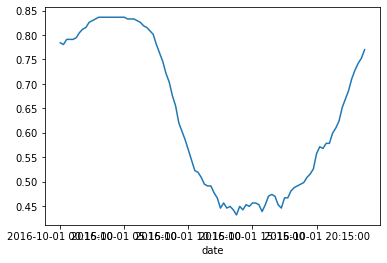

In [78]:
for w in range(1,2):
    seqs_normal[w:w+96][9].plot()

In [213]:
for w in range(5,10):          
    plot = train.generate()
    fig = plot.get_figure()
    fig.savefig("generated/gen_data/gen_"+str(w)+".png")
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
node_f

,total_space,monthly_fee,住宅,公共,写字楼,商业
0,0.200000,0.375000,0,0,1,0
1,0.900000,0.416667,0,0,1,0
2,0.173333,0.750000,0,0,0,1
3,0.266667,0.091667,1,0,0,0
4,0.486667,0.091667,1,0,0,0
5,1.000000,0.250000,0,1,0,0
6,0.600000,0.416667,0,0,1,0
7,0.620000,0.091667,0,0,1,0
8,0.320000,1.000000,0,0,0,1
9,0.386667,0.208333,1,0,0,0
